In [1]:
import pandas as pd
import statistics
import numpy as np
import seaborn as sns
import tabulate
import matplotlib.pyplot as plt
from fastdtw import fastdtw  #Package pour calculer les distances entre 2 séries de tailles différentes
from matplotlib.lines import Line2D
import concurrent.futures
import json

# Exploratory Data Analysis

## Loading and creating different dataframes

In [2]:
df=pd.read_json("Data/match_1.json")
df2=pd.read_json("Data/match_2.json")

full_df = pd.concat([df,df2])
full_df.reset_index(drop=True, inplace=True)

In [3]:
df['longueur'] = df['norm'].apply(lambda x: len(x))
df2['longueur'] = df2['norm'].apply(lambda x: len(x))
full_df['longueur'] = full_df['norm'].apply(lambda x: len(x))
full_df['mean'] = full_df['norm'].apply(lambda x: statistics.mean(x))

In [4]:
Full_data_1 = df['norm'].explode().reset_index(drop=True)
Full_data_2 = df2['norm'].explode().reset_index(drop=True)
Game_1 = df.explode('norm')[['label','norm']].reset_index(drop=True)
Game_2 = df2.explode('norm')[['label','norm']].reset_index(drop=True)
# Create a dictionary to map string labels to integer values
label_mapping = {'walk': 0, 'rest': 1, 'run': 2, 'tackle': 3, 'dribble': 4, 'pass': 5, 'cross': 6, 'shot': 7, 'no action': 8}
# Convert string labels to integers using list comprehension
Game_1['label'] = [label_mapping[label] for label in Game_1['label']]
Game_2['label'] = [label_mapping[label] for label in Game_2['label']]

## Statistical Analysis

In [5]:
def calculate_statistics(series):
    mean_value = series.mean()
    median_value = series.median()
    std_deviation = series.std()
    percentile_95 = series.quantile(0.95)
    max_val = series.max()
    min_val = series.min()

    
    return mean_value, median_value, std_deviation, percentile_95, max_val, min_val

In [6]:
actions = {}
for label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot', 'no action']:
    combin_lab = full_df[full_df['label']==label]
    lab_df = combin_lab['norm'].explode()

    mean, median, std, percentile_95, max_val, min_val = calculate_statistics(lab_df)

    print("STATISTICS FOR THE ACTION : ", label)
    print("Mean:", mean)
    print("Median:", median)
    print("Standard Deviation:", std)
    print("95th Percentile:", percentile_95)
    print("Max :", max_val)
    print("Min :", min_val)
    print("--------------------")
    print("\n")


    actions[label] = {
        'mean': mean,
        'std': std,
        '95 per': percentile_95,
        'median': median
    }


    del mean, median, std, percentile_95, max_val, min_val, lab_df, combin_lab

STATISTICS FOR THE ACTION :  walk
Mean: 28.320189265213653
Median: 23.780701942807543
Standard Deviation: 15.13108615609897
95th Percentile: 52.84842639752487
Max : 549.5750681191864
Min : 1.999615484483988
--------------------


STATISTICS FOR THE ACTION :  rest
Mean: 21.741159926079078
Median: 20.769884284937664
Standard Deviation: 4.603694214771405
95th Percentile: 28.615552580136672
Max : 101.9427471459145
Min : 5.072868360471503
--------------------


STATISTICS FOR THE ACTION :  run
Mean: 53.2052595508952
Median: 43.03405727070558
Standard Deviation: 46.913965269558034
95th Percentile: 120.79841204367143
Max : 759.8614139522053
Min : 1.674629720598801
--------------------


STATISTICS FOR THE ACTION :  tackle
Mean: 65.58008355251444
Median: 44.771698256303644
Standard Deviation: 75.07931691290578
95th Percentile: 182.92057566536664
Max : 739.2771908152429
Min : 3.561441685329417
--------------------


STATISTICS FOR THE ACTION :  dribble
Mean: 57.36999217117668
Median: 45.3542581

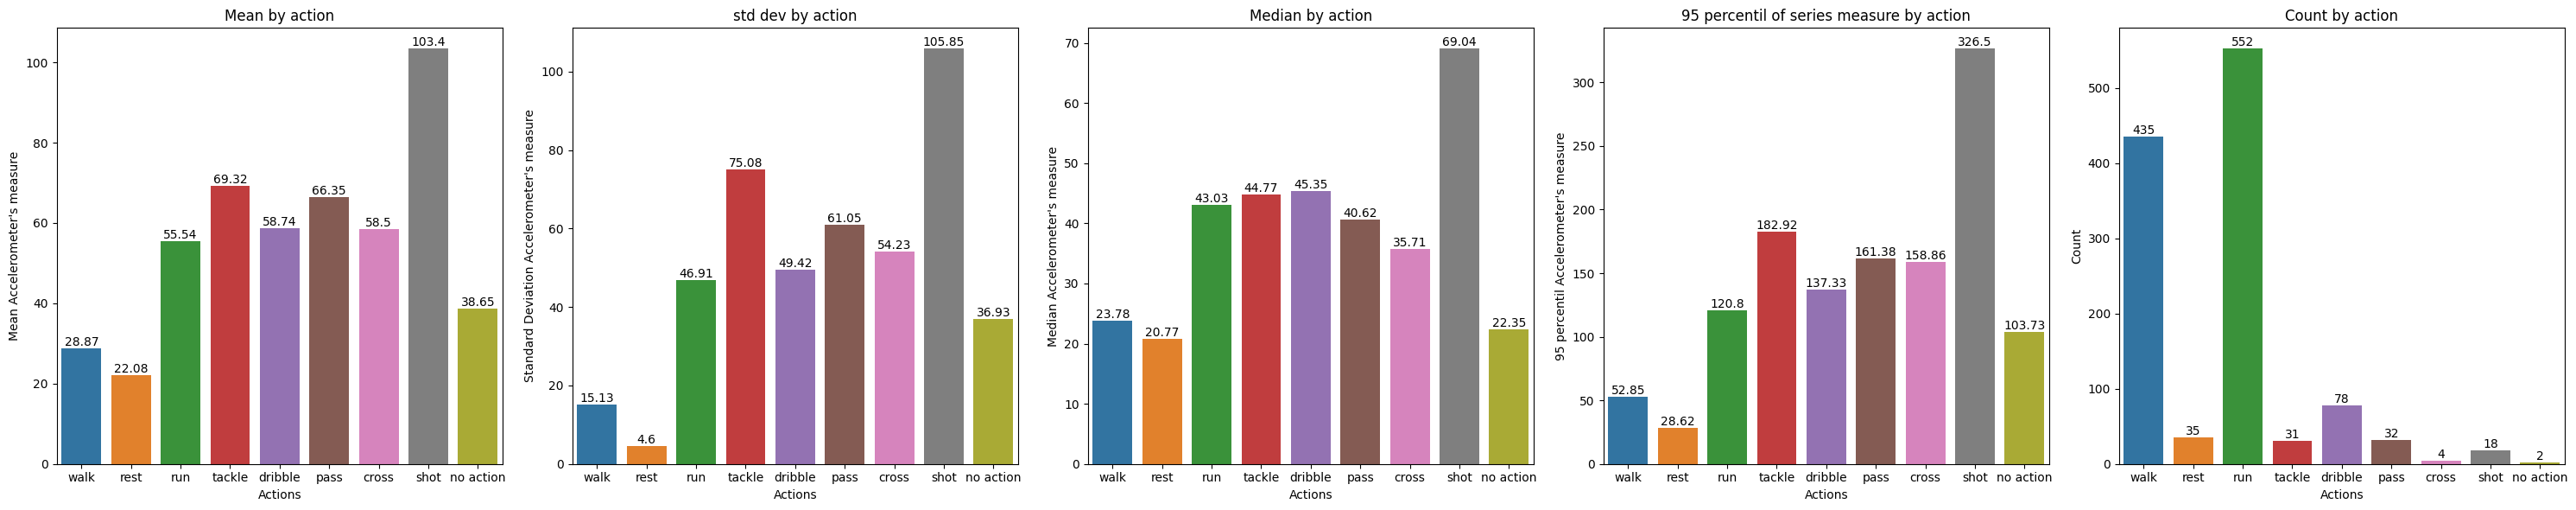

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(30, 6))
unique_labels = full_df['label'].unique()

sns.barplot(x=unique_labels, y=full_df.groupby('label')['mean'].mean().reindex(unique_labels).values, ax=axes[0])
axes[0].set_xlabel('Actions')
axes[0].set_ylabel('Mean Accelerometer\'s measure')
axes[0].set_title('Mean by action')
axes[0].bar_label(axes[0].containers[0], labels=np.round(full_df.groupby('label')['mean'].mean().reindex(unique_labels).values,2))

sns.barplot(x=unique_labels, y=pd.DataFrame(actions).T['std'].values, ax=axes[1])
axes[1].set_xlabel('Actions')
axes[1].set_ylabel('Standard Deviation Accelerometer\'s measure')
axes[1].set_title('std dev by action')
axes[1].bar_label(axes[1].containers[0], labels=np.round(pd.DataFrame(actions).T['std'].values,2))

sns.barplot(x=unique_labels, y=pd.DataFrame(actions).T['median'].values, ax=axes[2])
axes[2].set_xlabel('Actions')
axes[2].set_ylabel('Median Accelerometer\'s measure')
axes[2].set_title('Median by action')
axes[2].bar_label(axes[2].containers[0], labels=np.round(pd.DataFrame(actions).T['median'].values,2))

sns.barplot(x=unique_labels, y=pd.DataFrame(actions).T['95 per'].values, ax=axes[3])
axes[3].set_xlabel('Actions')
axes[3].set_ylabel('95 percentil Accelerometer\'s measure')
axes[3].set_title('95 percentil of series measure by action')
axes[3].bar_label(axes[3].containers[0], labels=np.round(pd.DataFrame(actions).T['95 per'].values,2))

sns.barplot(x=unique_labels, y=full_df.groupby('label').agg(['count'])['norm']['count'].reindex(unique_labels), ax=axes[4])
axes[4].set_xlabel('Actions')
axes[4].set_ylabel('Count')
axes[4].set_title('Count by action')
axes[4].bar_label(axes[4].containers[0], labels=full_df.groupby('label').agg(['count'])['norm']['count'].reindex(unique_labels))


plt.tight_layout()

# Show the combined plot
plt.show()

- **Cross** and **no action** actions have low occurrence in the dataset, making them unsuitable for in-depth analysis. Our focus will be on the more frequent **run** and **walk** actions, where a detailed analysis is possible.

- The **shot** action stands out as the most significant based on the `norm` values, showing the highest mean and standard deviation.

- On the other hand, the **rest** action appears to be the least significant, with the lowest mean and standard deviation.

- The **walk** action, while somewhat similar to **rest**, exhibits slightly more variability, indicated by a higher standard deviation.

- Actions like **run**, **tackle**, **dribble**, and **pass** are quite similar, with median values ranging from 40 to 45. However, it's worth noting that **tackle** appears to have higher variability, as suggested by its higher standard deviation.


Now let's have a look at the length of each actions, or the "gait" as you called it.

In [8]:
Long = {}
for label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot', 'no action']:
    combin_lab = full_df[full_df['label']==label]
    lab_df = combin_lab['longueur'].explode()

    mean, median, std, percentile_95, max_val, min_val = calculate_statistics(lab_df)

    print("STATISTICS FOR THE ACTION : ", label)
    print("Mean:", mean)
    print("Median:", median)
    print("Standard Deviation:", std)
    print("95th Percentile:", percentile_95)
    print("Max :", max_val)
    print("Min :", min_val)
    print("--------------------")
    print("\n")


    Long[label] = {
        'mean': mean,
        'std': std,
        '95 per': percentile_95,
        'median': median
    }


    del mean, median, std, percentile_95, max_val, min_val, lab_df, combin_lab

STATISTICS FOR THE ACTION :  walk
Mean: 55.326436781609196
Median: 54.0
Standard Deviation: 17.245292283339662
95th Percentile: 79.59999999999991
Max : 179
Min : 8
--------------------


STATISTICS FOR THE ACTION :  rest
Mean: 115.77142857142857
Median: 76.0
Standard Deviation: 124.03654246046291
95th Percentile: 248.8999999999998
Max : 723
Min : 18
--------------------


STATISTICS FOR THE ACTION :  run
Mean: 37.65760869565217
Median: 35.0
Standard Deviation: 13.681116056741743
95th Percentile: 64.89999999999986
Max : 94
Min : 1
--------------------


STATISTICS FOR THE ACTION :  tackle
Mean: 46.225806451612904
Median: 40.0
Standard Deviation: 24.13532635981175
95th Percentile: 101.0
Max : 118
Min : 20
--------------------


STATISTICS FOR THE ACTION :  dribble
Mean: 39.256410256410255
Median: 36.0
Standard Deviation: 17.30132935170004
95th Percentile: 66.14999999999999
Max : 100
Min : 3
--------------------


STATISTICS FOR THE ACTION :  pass
Mean: 42.6875
Median: 33.0
Standard Devia

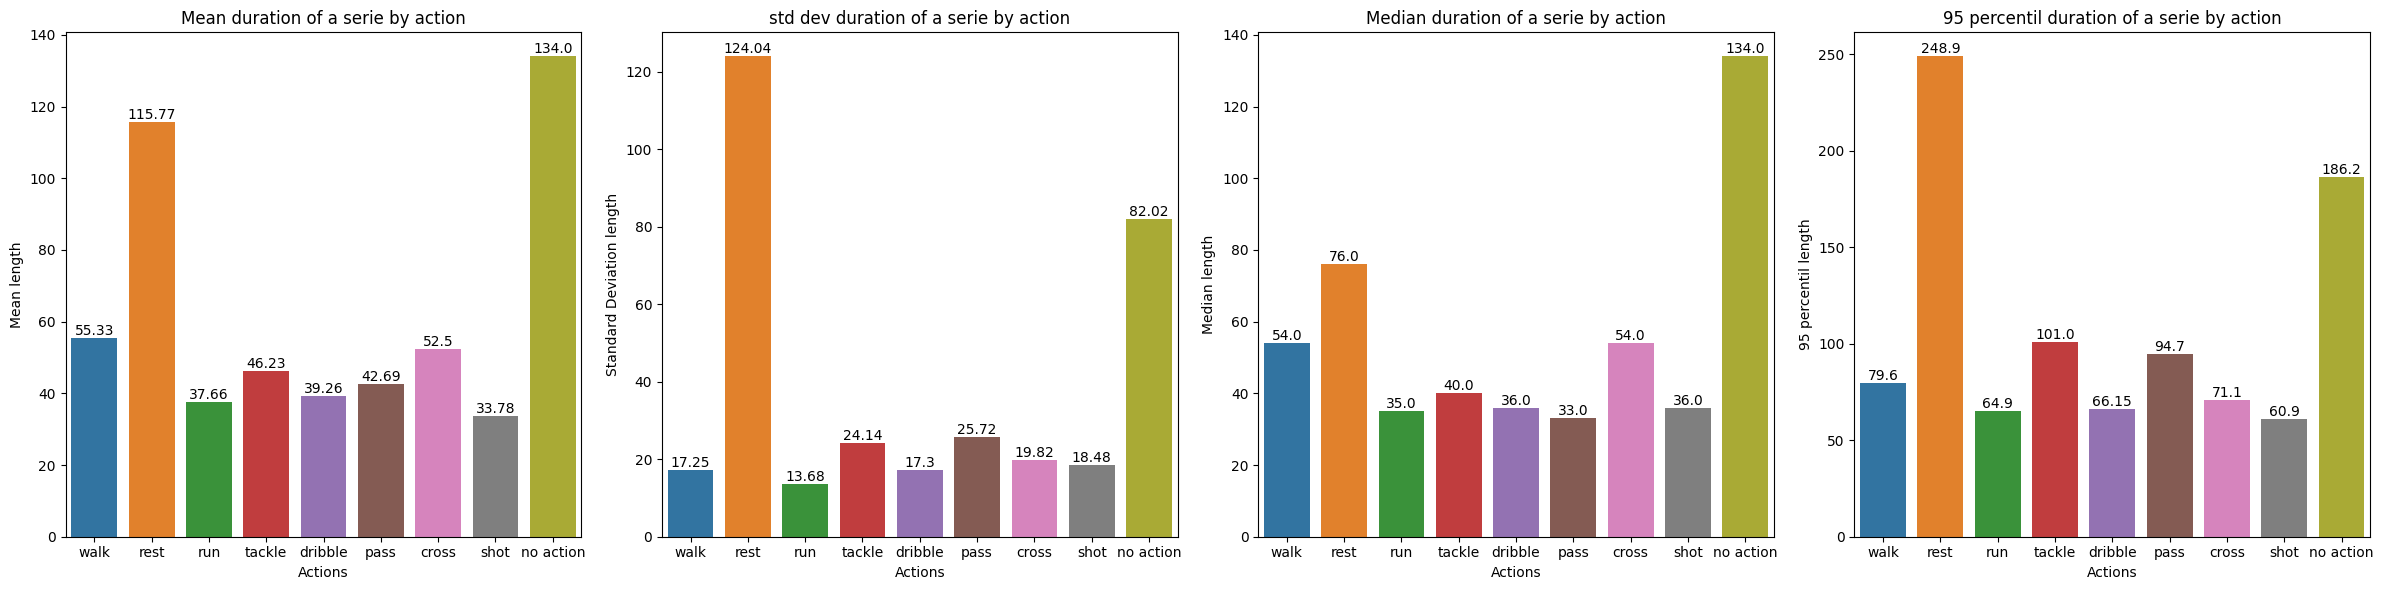

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
unique_labels = full_df['label'].unique()

sns.barplot(x=unique_labels, y=full_df.groupby('label')['longueur'].mean().reindex(unique_labels).values, ax=axes[0])
axes[0].set_xlabel('Actions')
axes[0].set_ylabel('Mean length')
axes[0].set_title('Mean duration of a serie by action')
axes[0].bar_label(axes[0].containers[0], labels=np.round(full_df.groupby('label')['longueur'].mean().reindex(unique_labels).values,2))


sns.barplot(x=unique_labels, y=pd.DataFrame(Long).T['std'].values, ax=axes[1])
axes[1].set_xlabel('Actions')
axes[1].set_ylabel('Standard Deviation length')
axes[1].set_title('std dev duration of a serie by action')
axes[1].bar_label(axes[1].containers[0], labels=np.round(pd.DataFrame(Long).T['std'].values,2))


sns.barplot(x=unique_labels, y=pd.DataFrame(Long).T['median'].values, ax=axes[2])
axes[2].set_xlabel('Actions')
axes[2].set_ylabel('Median length')
axes[2].set_title('Median duration of a serie by action')
axes[2].bar_label(axes[2].containers[0], labels=np.round(pd.DataFrame(Long).T['median'].values,2))


sns.barplot(x=unique_labels, y=pd.DataFrame(Long).T['95 per'].values, ax=axes[3])
axes[3].set_xlabel('Actions')
axes[3].set_ylabel('95 percentil length')
axes[3].set_title('95 percentil duration of a serie by action')
axes[3].bar_label(axes[3].containers[0], labels=np.round(pd.DataFrame(Long).T['95 per'].values,2))



plt.tight_layout()

# Show the combined plot
plt.show()

- The **rest** action stands out as the longest action of the dataset. It lasts on average almost 2 seconds, but it also has the highest variability.

- The **run** action is quite short in length with little variability.

Given the little information that we managed to deduced over the different actions, we can try to see if these actions have a higher probability to happen at certain time of the game (ie : Do we have for instance more tackle at the begining of the game)

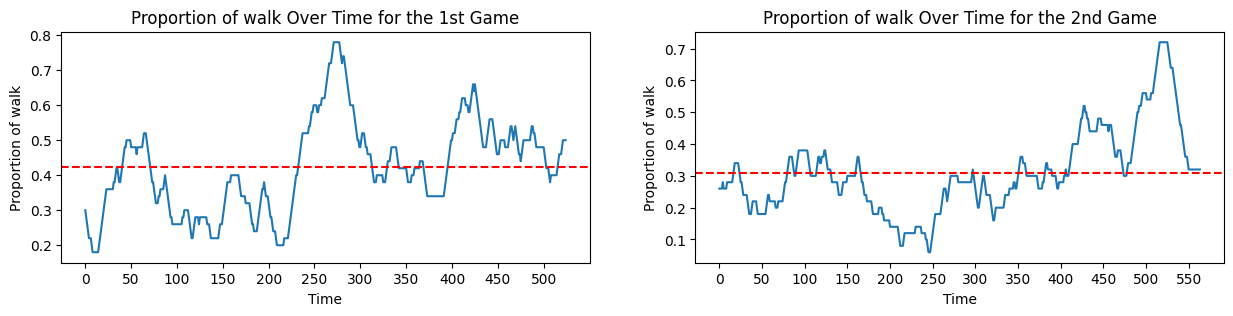

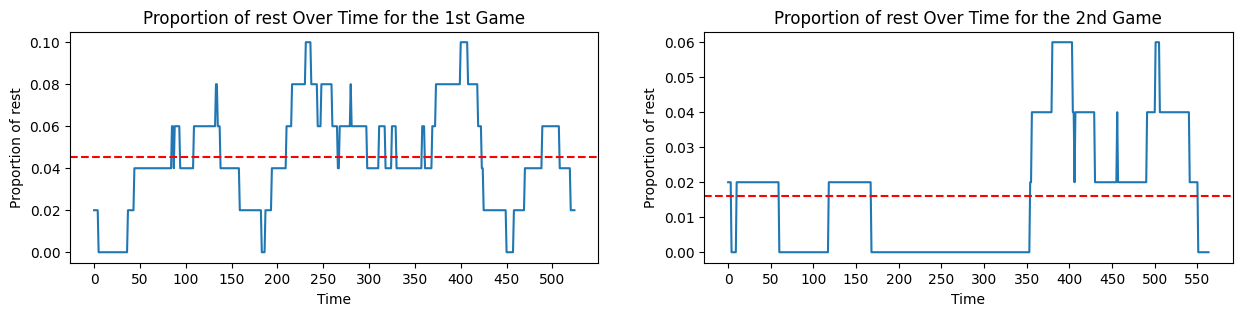

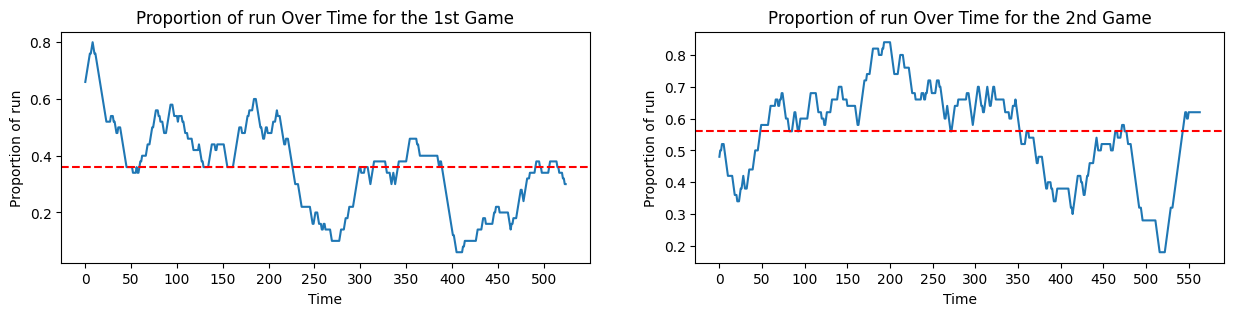

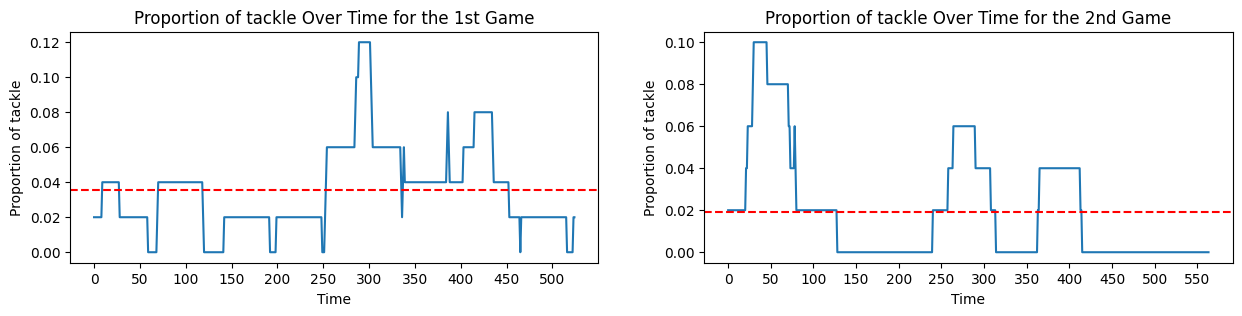

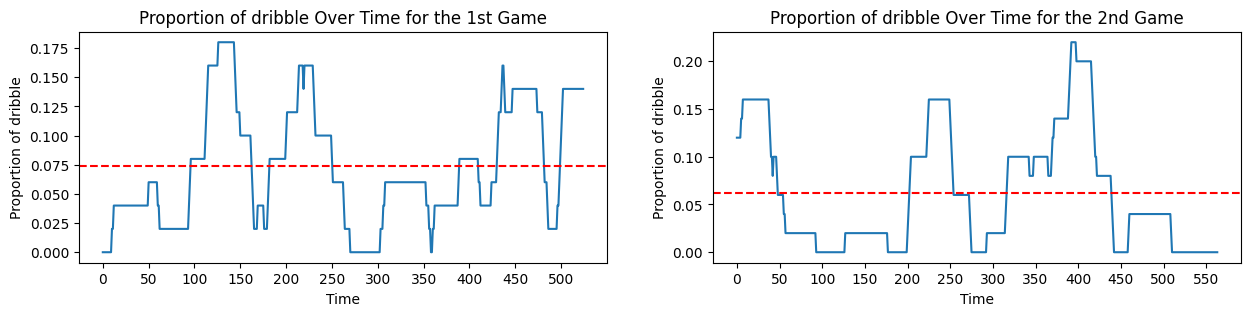

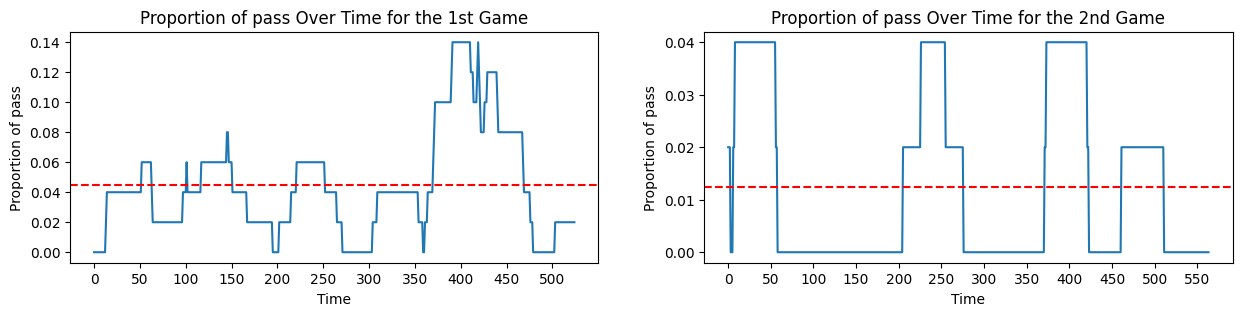

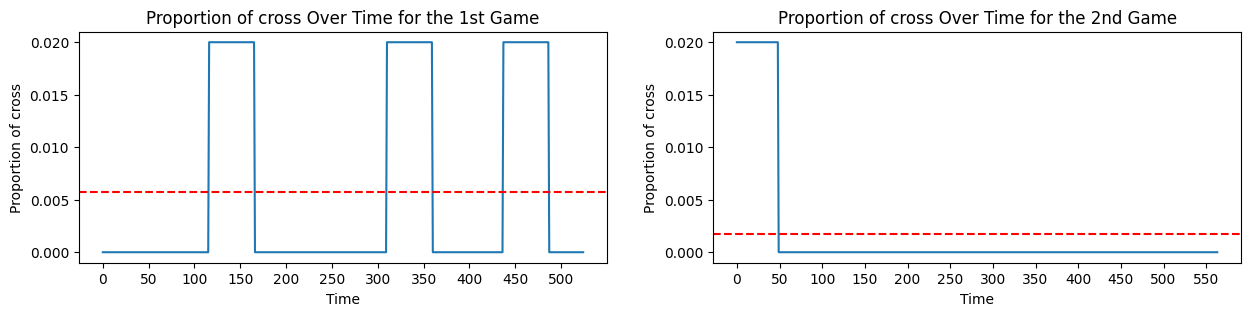

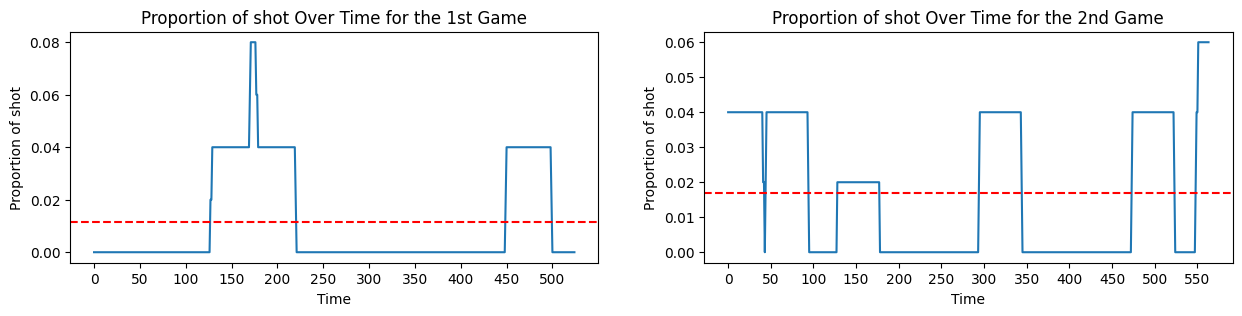

In [10]:
# Define the size of the moving window
window_size = 50
for labels in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot']:
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    # Calculate the proportion of the target label within each window
    proportions_1 = [
        sum(1 for label in df['label'][i:i + window_size] if label == labels) / window_size
        for i in range(len(df['label']) - window_size + 1)
    ]

    mean_proportion_1 = sum(proportions_1) / len(proportions_1)


    sns.lineplot(
        x = range(len(proportions_1)),
        y = proportions_1,
        ax=axes[0])
    axes[0].axhline(y=mean_proportion_1, color='r', linestyle='--', label='Mean Proportion')

    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Proportion of ' + labels)
    axes[0].set_title('Proportion of ' + labels + ' Over Time for the 1st Game')
    axes[0].set_xticks(range(0, len(proportions_1), 50))



    proportions_2 = [
        sum(1 for label in df2['label'][i:i + window_size] if label == labels) / window_size
        for i in range(len(df2['label']) - window_size + 1)
    ]

    mean_proportion_2 = sum(proportions_2) / len(proportions_2)

    sns.lineplot(
        x = range(len(proportions_2)),
        y = proportions_2,
        ax=axes[1])
    axes[1].axhline(y=mean_proportion_2, color='r', linestyle='--', label='Mean Proportion')

    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Proportion of ' + labels)
    axes[1].set_title('Proportion of ' + labels + ' Over Time for the 2nd Game')
    axes[1].set_xticks(range(0, len(proportions_2), 50))


    plt.show()

Looking at the 2 games, it doesn't look like anything is standing out. We can only notice (mainly because they represent the majority of the dataset) that when we have a high proportion of "run" at a certain point in the dataset, we have a low proportion of "walk," and vice versa.

Let's now have a look if the value of the norm  and the length of an action change during the game

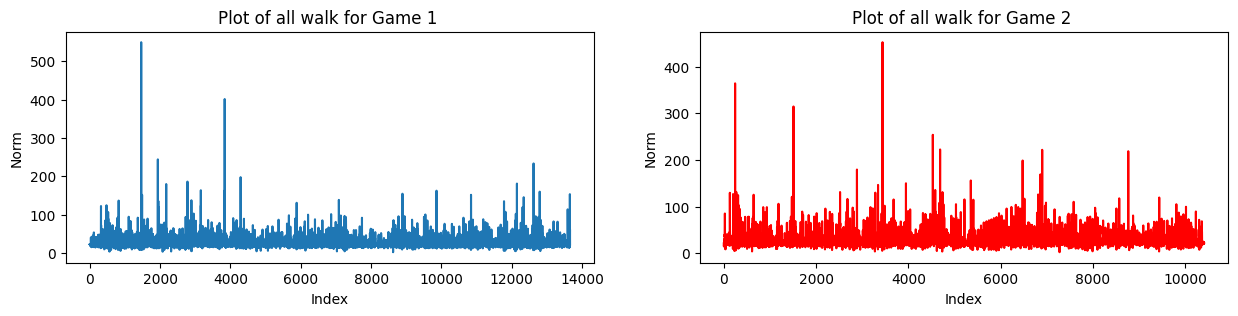

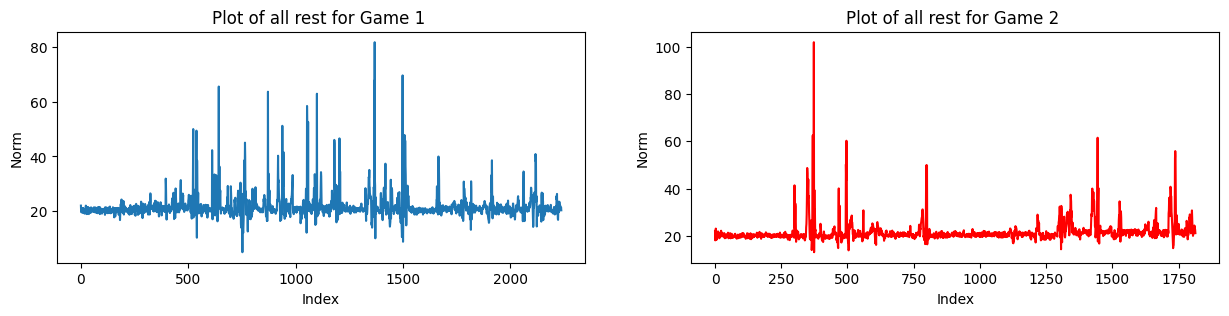

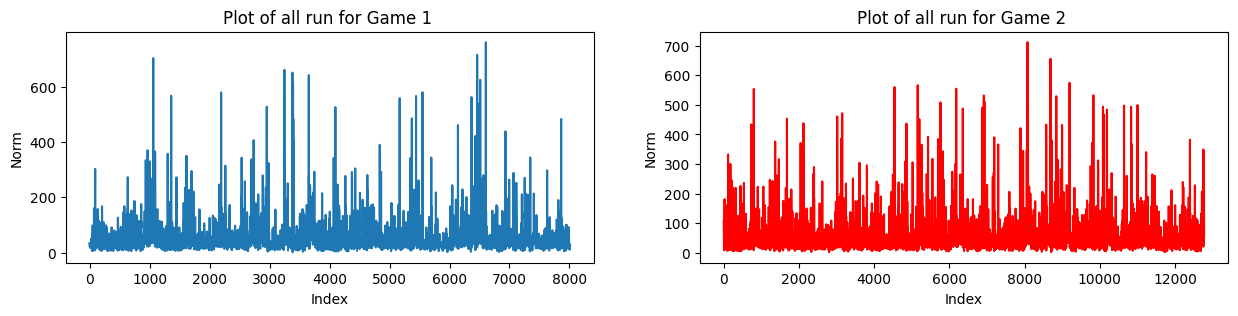

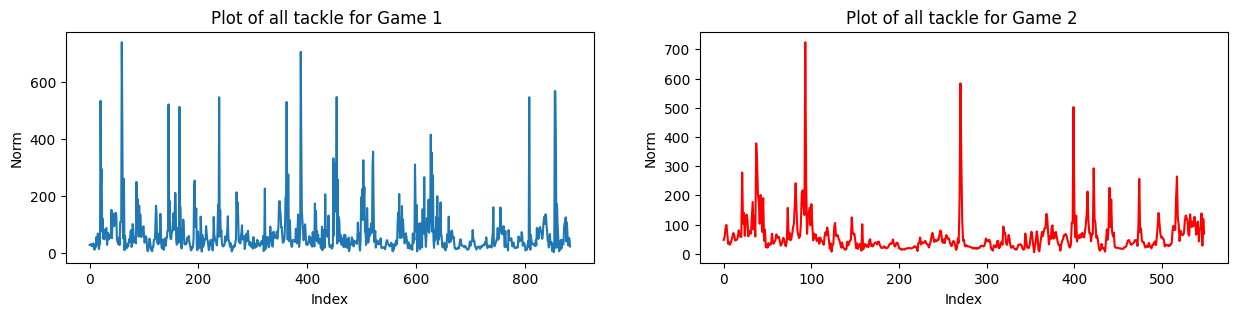

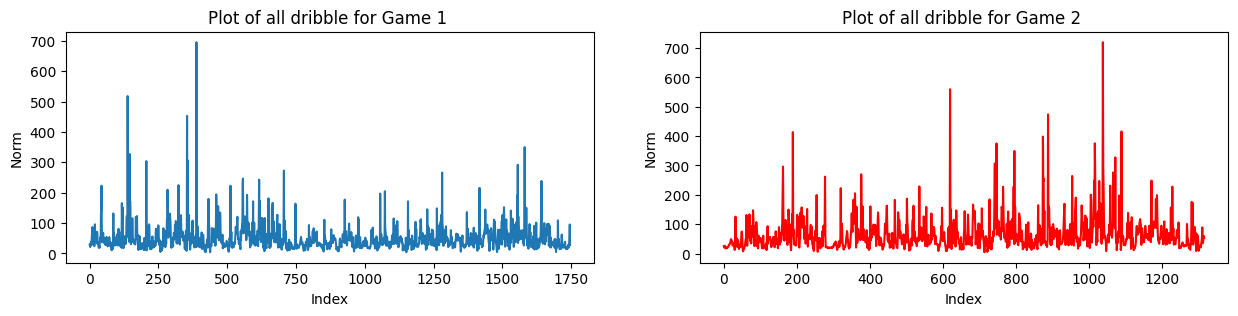

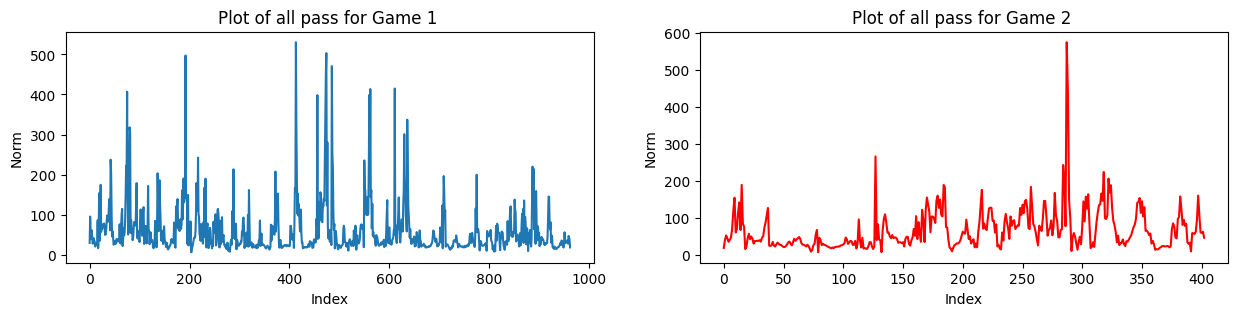

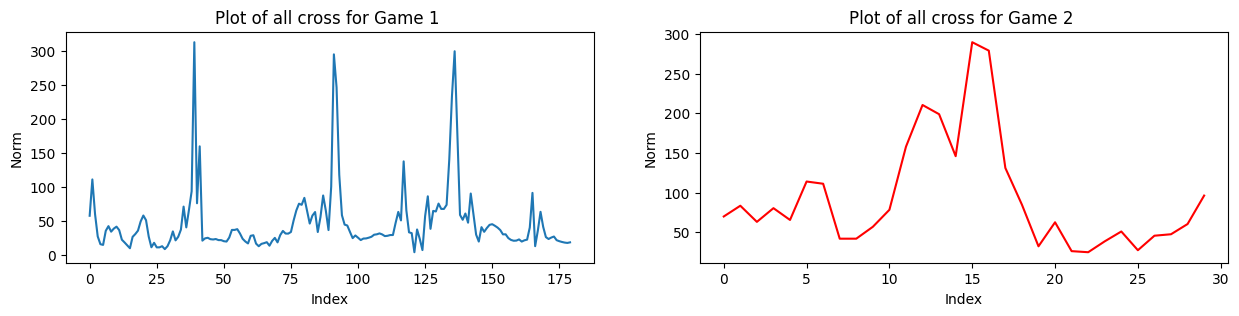

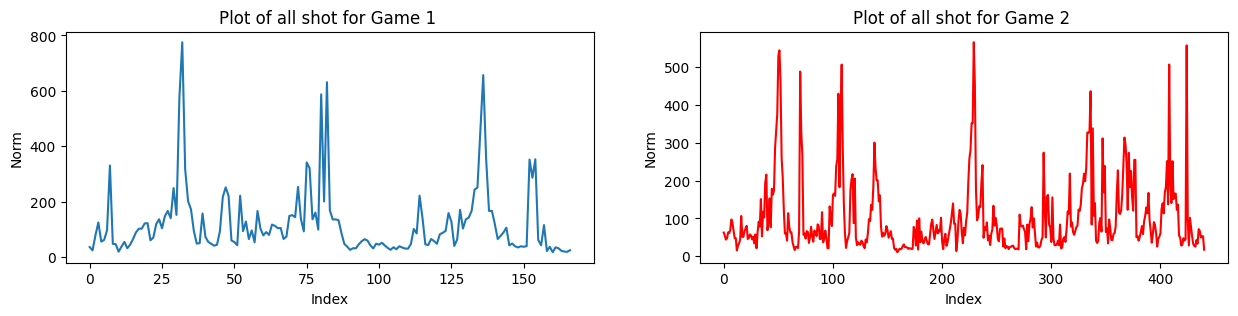

In [11]:
for i in range(8):
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))

                                                            

    sns.lineplot(
         x=range(len(Game_1[Game_1['label']==i]['norm'])), 
         y=Game_1[Game_1['label']==i]['norm'],
         ax=axes[0])
    sns.lineplot(
         x=range(len(Game_2[Game_2['label']==i]['norm'])), 
         y=Game_2[Game_2['label']==i]['norm'],
         color='r',
         ax=axes[1])
    



    # Add labels and a title to the subplot
    axes[0].set_xlabel('Index')
    axes[0].set_ylabel('Norm')
    axes[0].set_title('Plot of all ' + ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot'][i] + ' for Game 1 ')

    axes[1].set_xlabel('Index')
    axes[1].set_ylabel('Norm')
    axes[1].set_title('Plot of all ' + ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot'][i] + ' for Game 2 ')



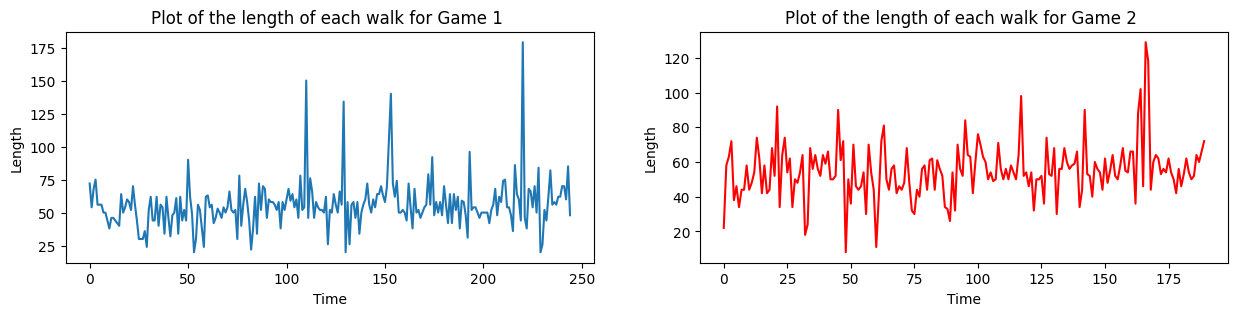

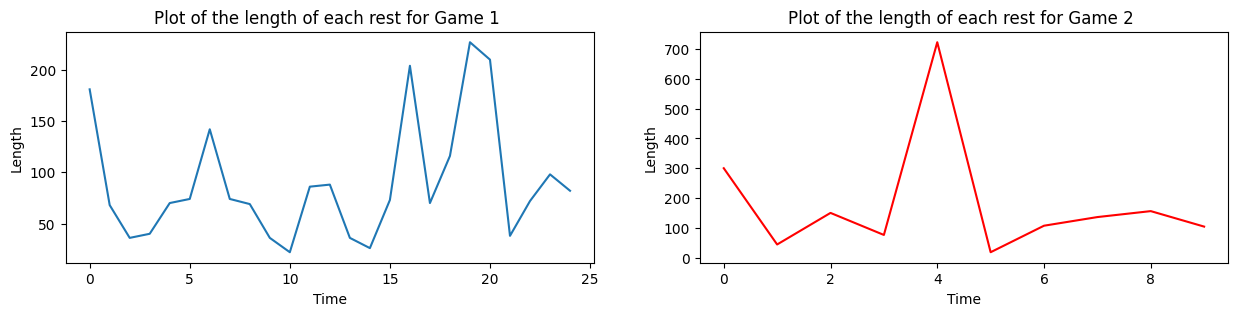

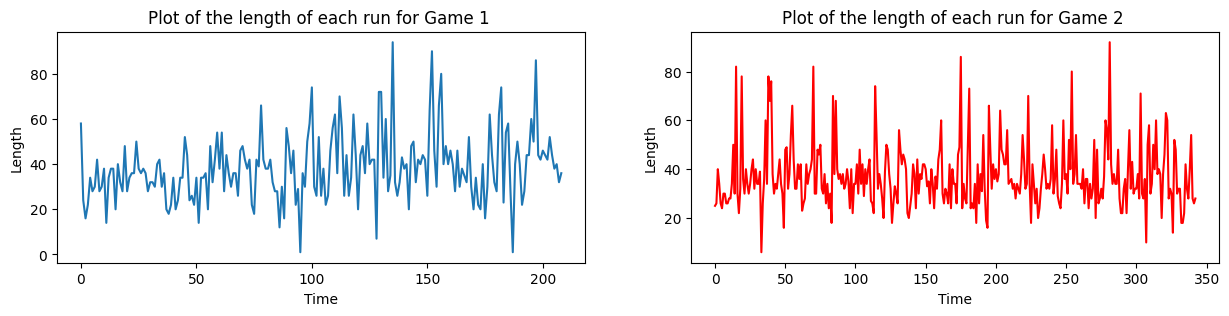

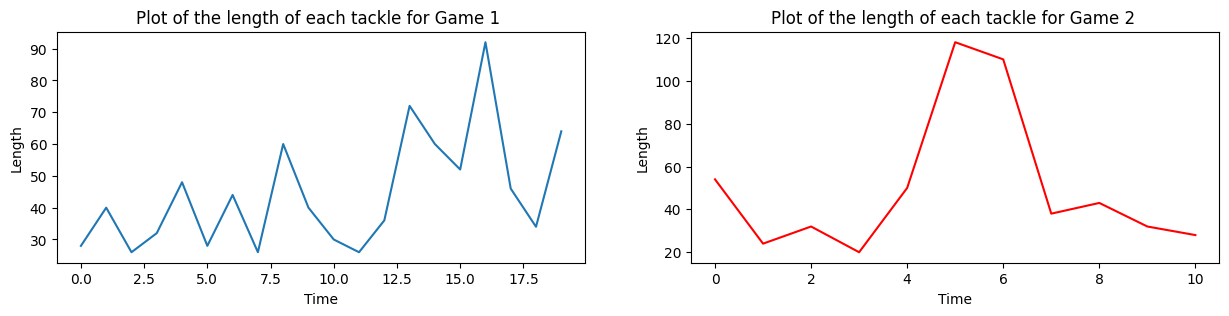

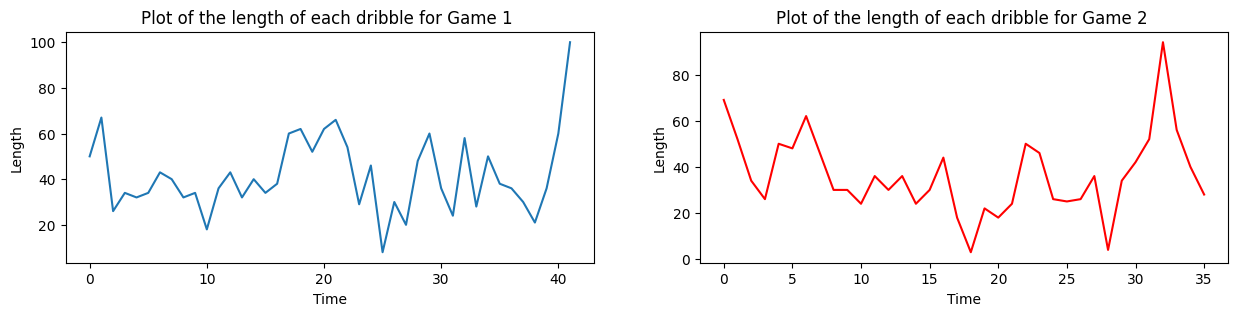

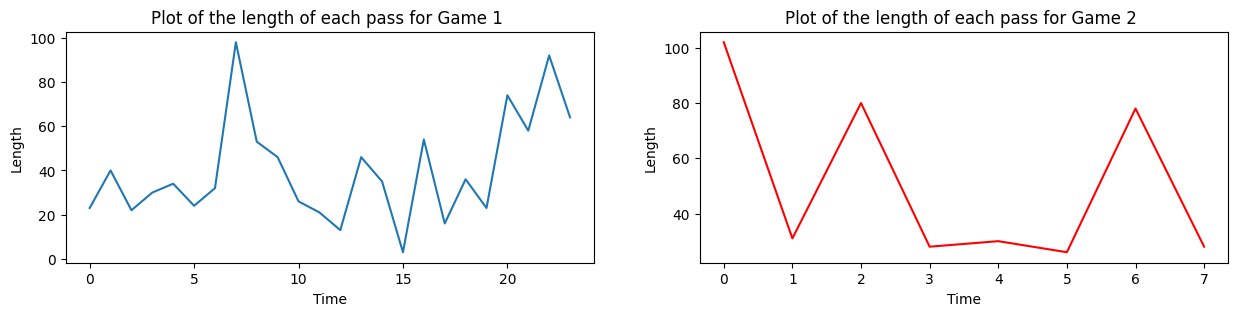

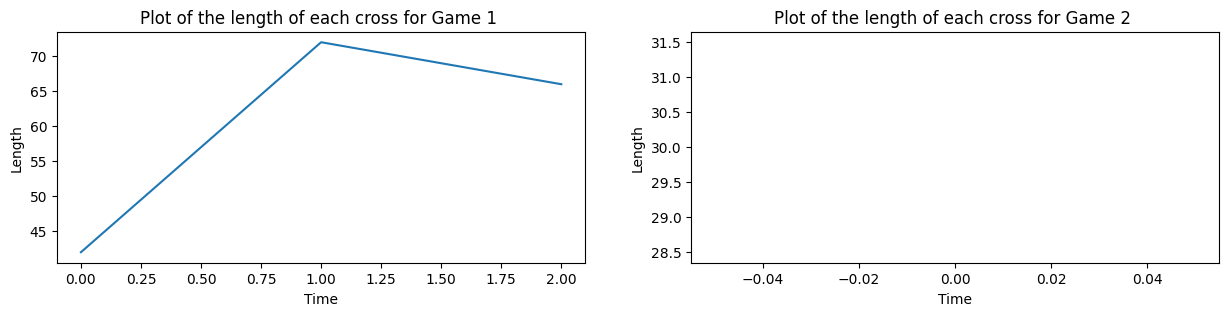

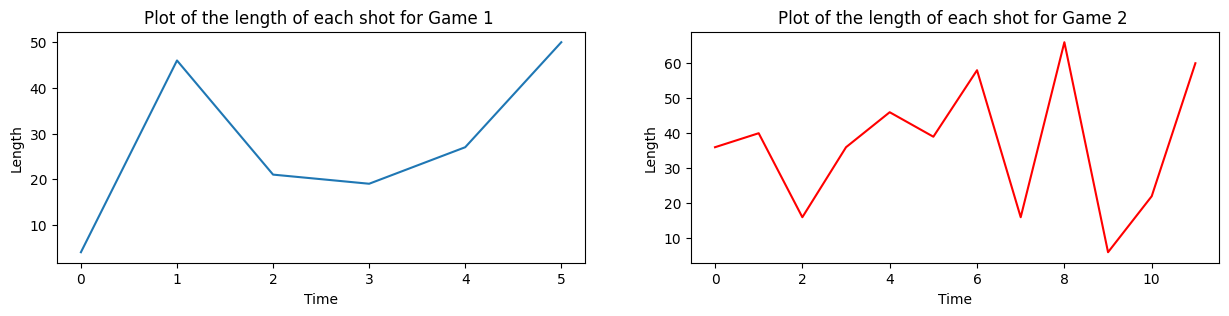

In [12]:
for label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot']:
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    sns.lineplot(
         x=range(len(df[df['label']==label]['longueur'])), 
         y=df[df['label']==label]['longueur'],
         ax=axes[0])
    sns.lineplot(
         x=range(len(df2[df2['label']==label]['longueur'])), 
         y=df2[df2['label']==label]['longueur'],
         color='r',
         ax=axes[1])
    # Add labels and a title to the subplot
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Length')
    axes[0].set_title('Plot of the length of each ' + label + ' for Game 1 ')

    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Length')
    axes[1].set_title('Plot of the length of each ' + label + ' for Game 2 ')


It doesn't look like there are any hypotheses we can make based on these graphs. When it appears that there is a trend for a specific action in one game, it's not present in the other game (and drawing conclusions from only 2 games may not be meaningful).

Let's now randomly select some series for each action to see if we can observe any patterns or behaviors.

4 random graphs for the action: walk
---------------------------------------------


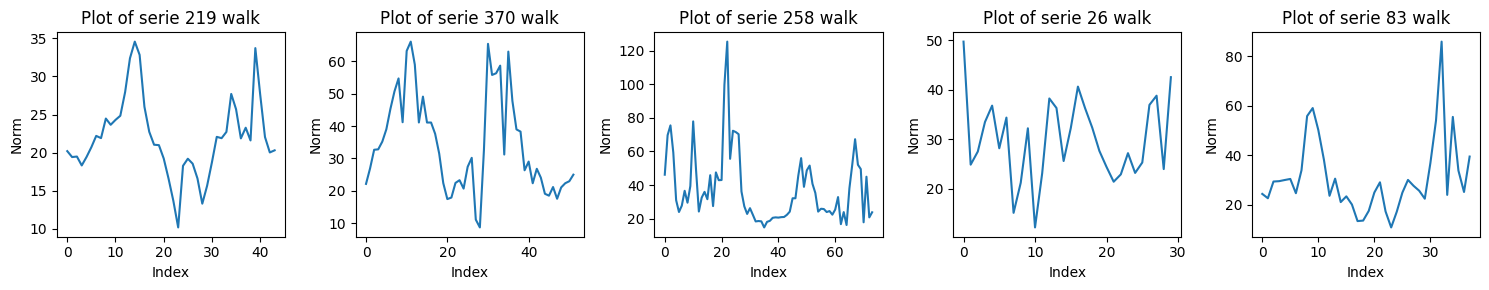

4 random graphs for the action: rest
---------------------------------------------


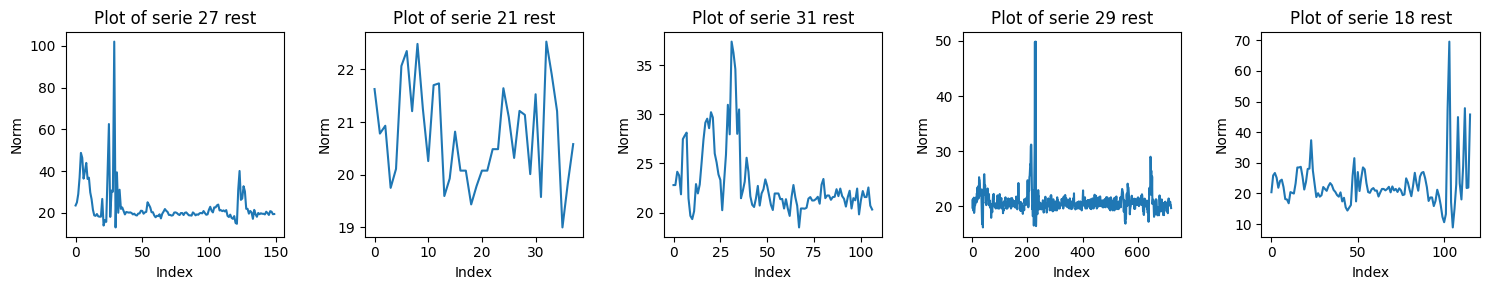

4 random graphs for the action: run
---------------------------------------------


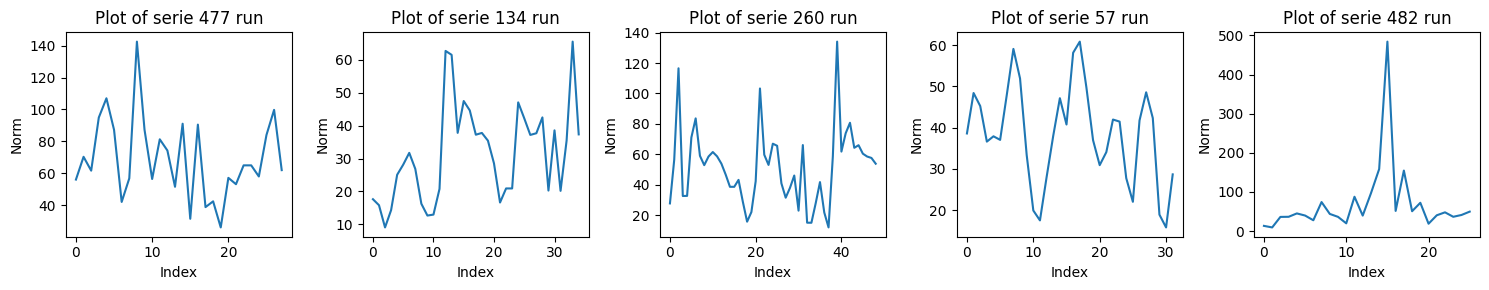

4 random graphs for the action: tackle
---------------------------------------------


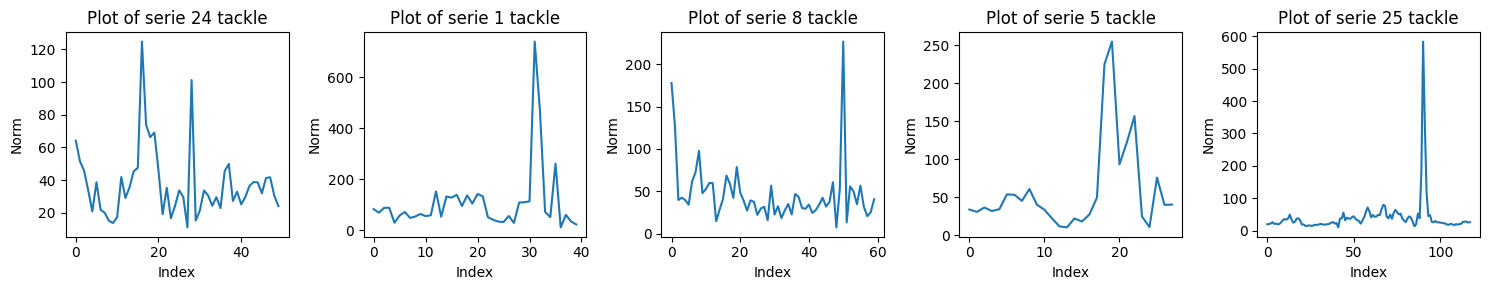

4 random graphs for the action: dribble
---------------------------------------------


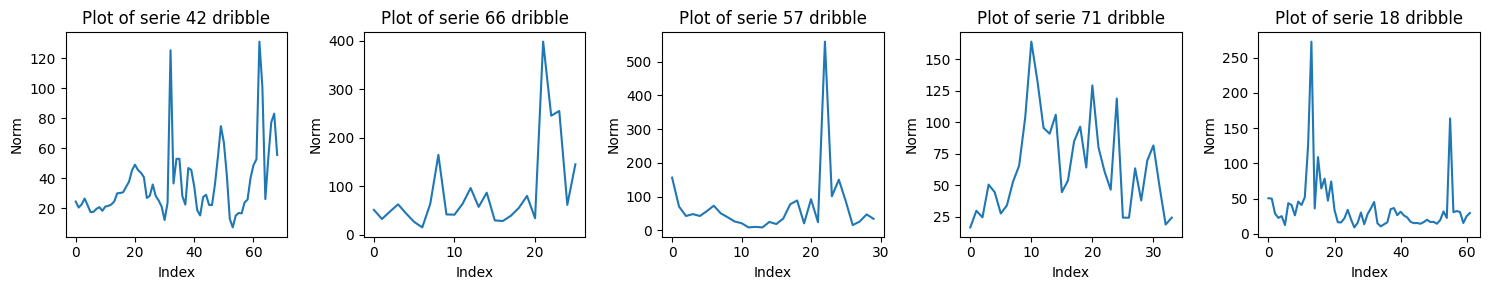

4 random graphs for the action: pass
---------------------------------------------


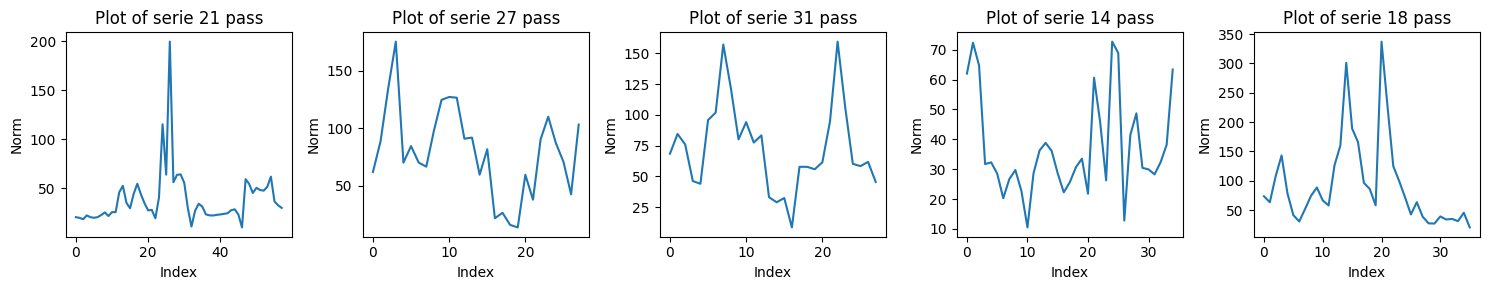

4 random graphs for the action: cross
---------------------------------------------


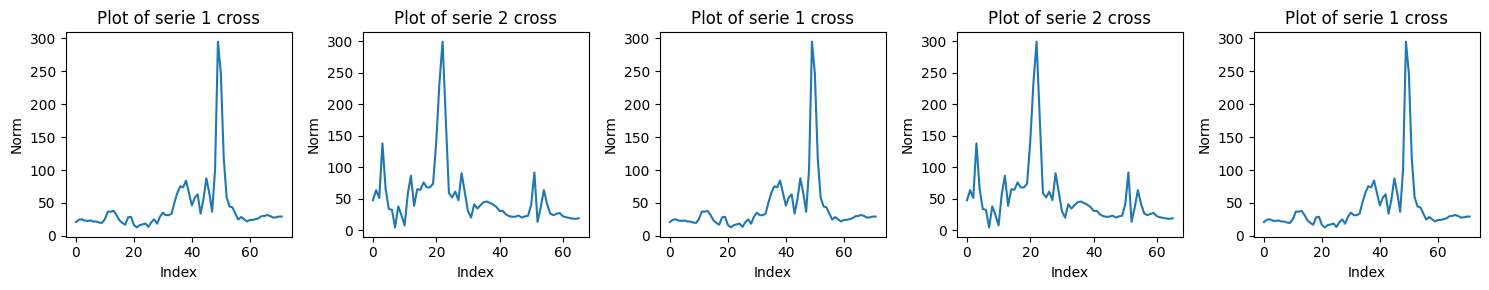

4 random graphs for the action: shot
---------------------------------------------


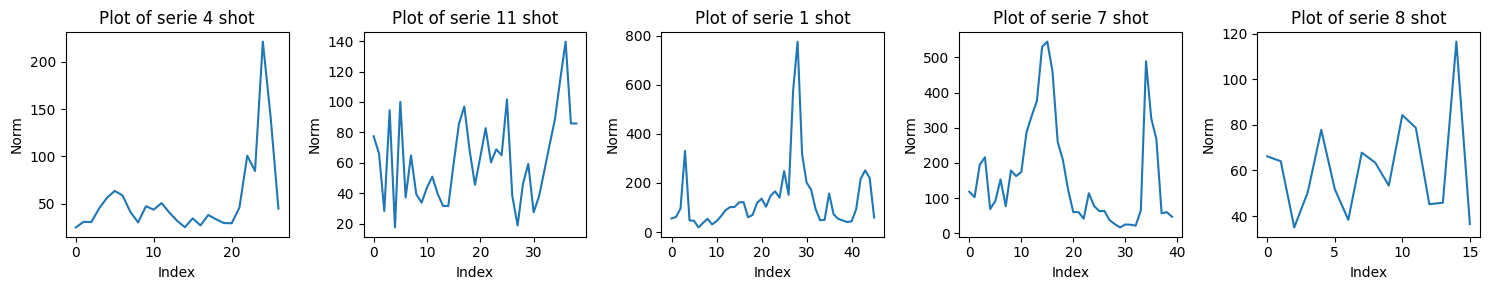

In [13]:
for label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot']:
    print('4 random graphs for the action: ' + label)
    print('---------------------------------------------')

    # Create a figure with 5 subplots (1 row, 5 columns)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    selected_indices = []
    for i in range(5):  # Generate 5 random plots
        # Generate a random index that is not in the selected_indices list
        while True:
            rand_int = np.random.randint(len(full_df[full_df['label'] == label]))
            if label == 'cross': #exception for cross that only have 4 apparitions
                break
            if rand_int not in selected_indices:
                selected_indices.append(rand_int)
                break

        # Create a line plot on the i-th subplot
        sns.lineplot(
            x=range(len(full_df[full_df['label'] == label]['norm'].iloc[rand_int])),
            y=full_df[full_df['label'] == label]['norm'].iloc[rand_int],
            ax=axes[i]  # Use the i-th subplot
        )

        # Add labels and a title to the subplot
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel('Norm')
        axes[i].set_title('Plot of serie ' + str(rand_int) + ' ' + label)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the subplots
    plt.show()

Let's have a look at the transition between 2 actions

In [14]:
def combine_lists(list1, list2):
    if len(list1) >= 5 and len(list2) >= 5:
        return list1[-5:] + list2[:5]
    elif len(list1) < 5 and len(list2) >= 5:
        return list1 + list2[:5 - len(list1)]
    elif len(list1) >= 5 and len(list2) < 5:
        return list1[-5 + len(list2):] + list2
    else:  # Both lists have fewer than 5 elements
        return list1 + list2

In [15]:
trans = []
From = full_df['label'][:-1].reset_index(drop=True)
To = full_df['label'][1:].reset_index(drop=True)
for i in range(1, len(full_df)):
    list1 = full_df['norm'].iloc[i-1]
    list2 = full_df['norm'].iloc[i]
    combined_list = combine_lists(list1, list2)
    trans.append(combined_list)
Transi_Game_1 = pd.DataFrame({'Action From': From, 'Action To': To, 'Serie trans': trans})
Transi_Game_1 = Transi_Game_1[Transi_Game_1['Serie trans'].apply(lambda x: len(x) == 10)].reset_index(drop=True)

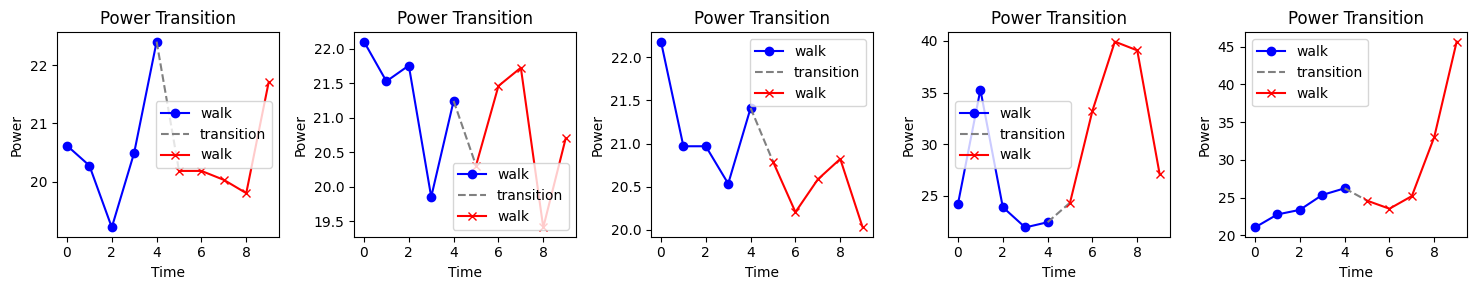

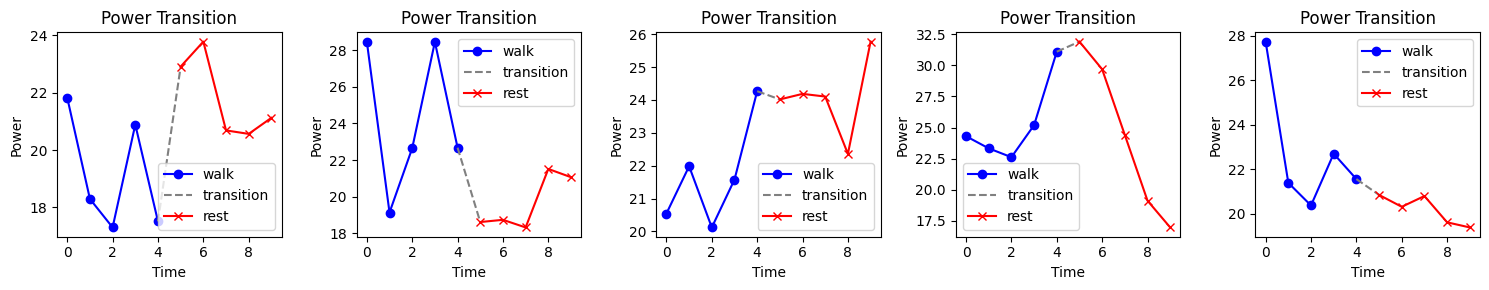

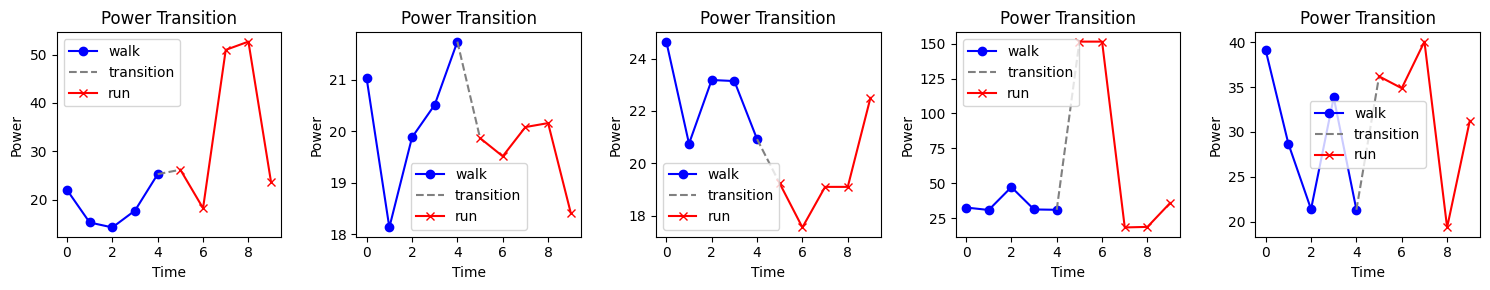

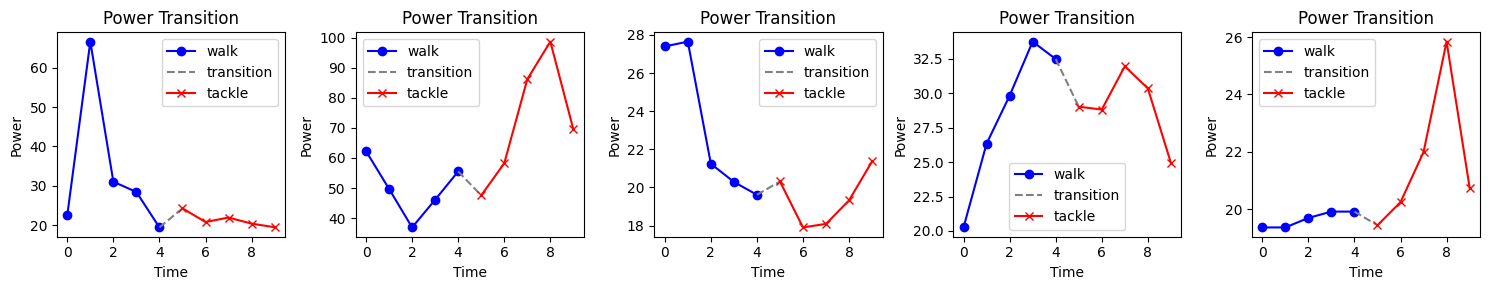

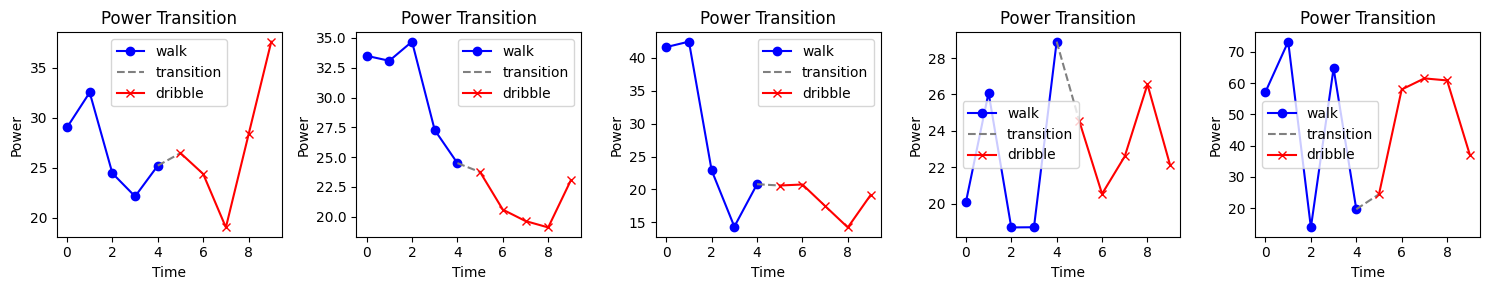

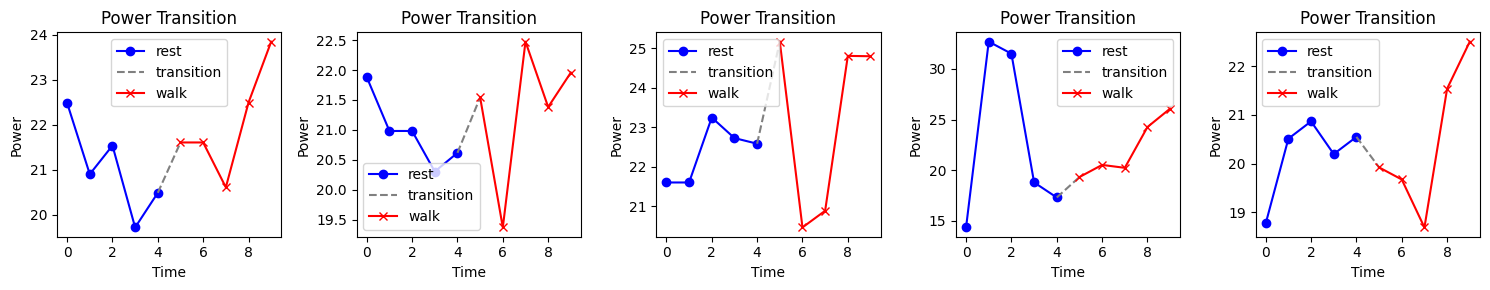

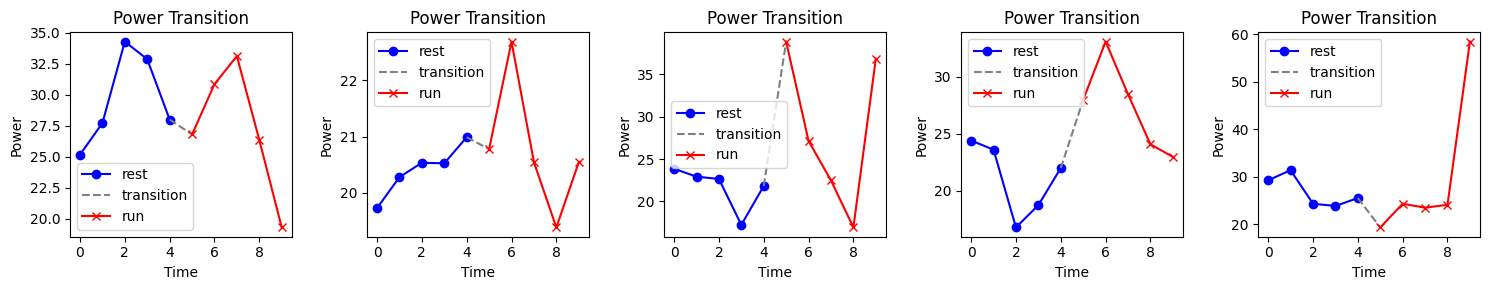

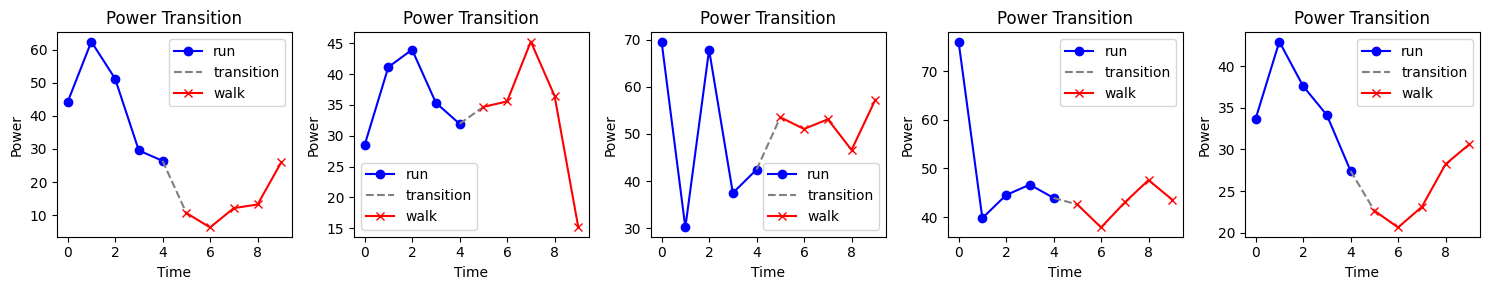

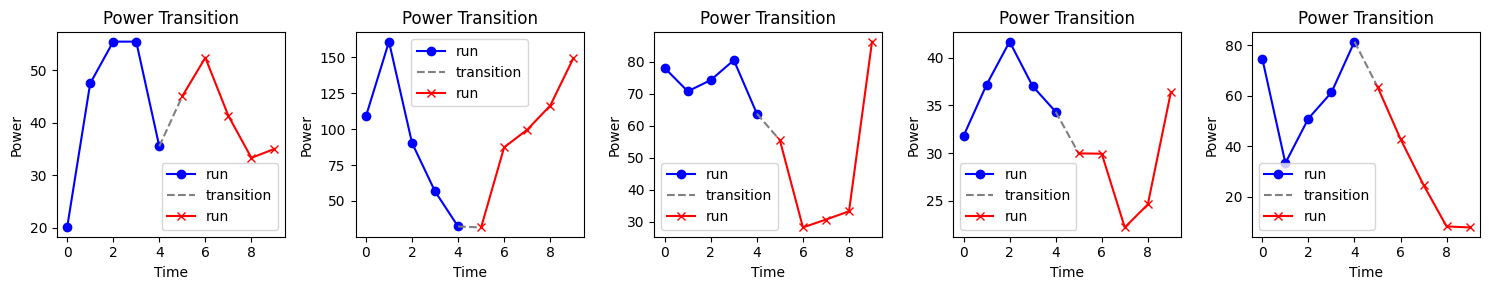

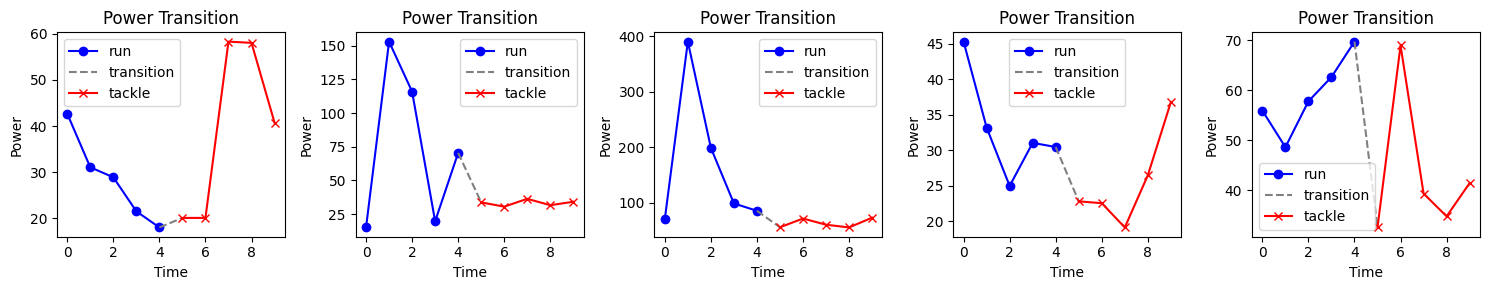

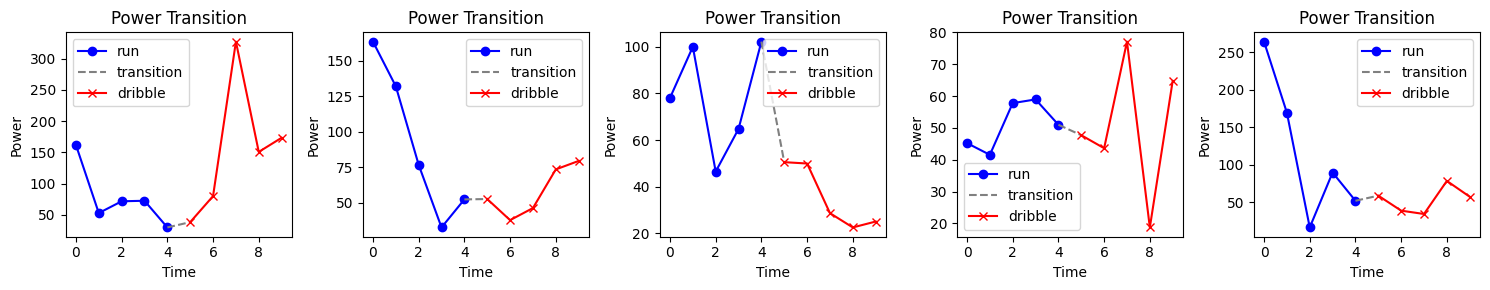

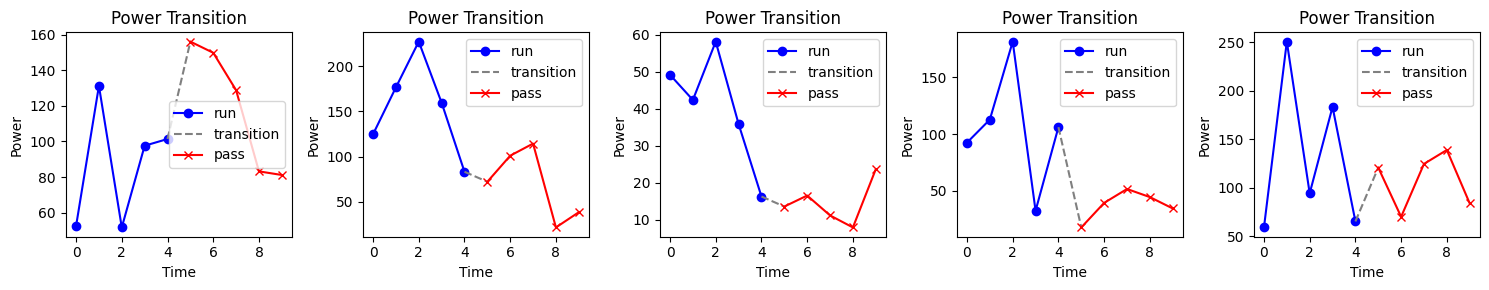

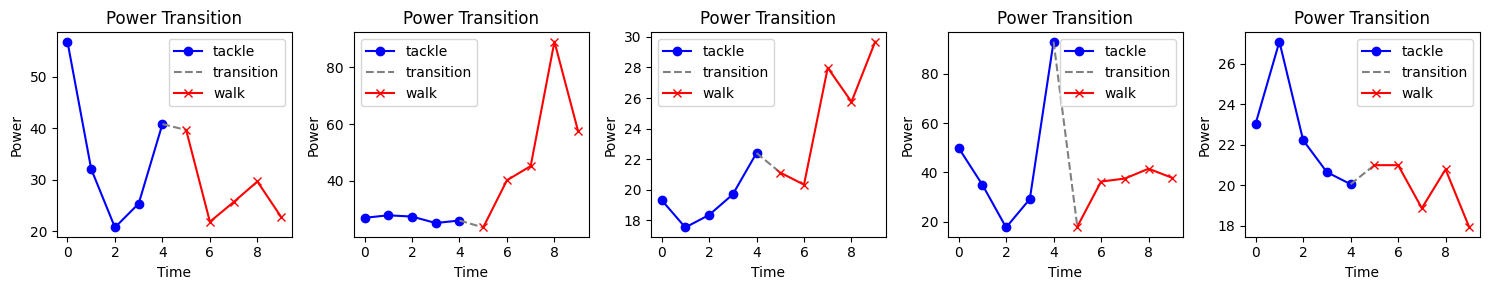

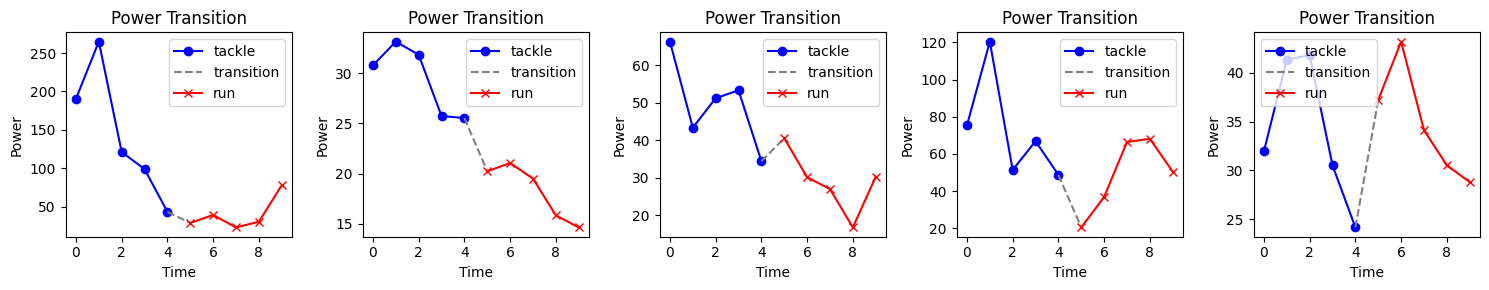

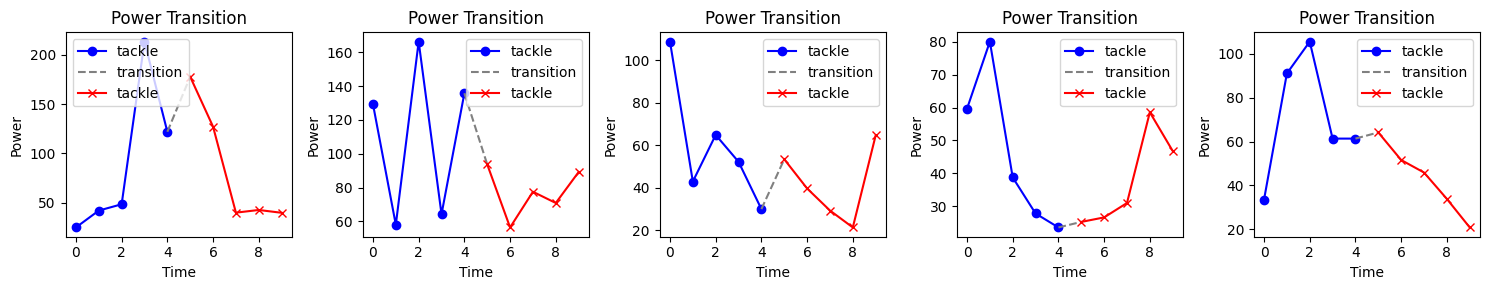

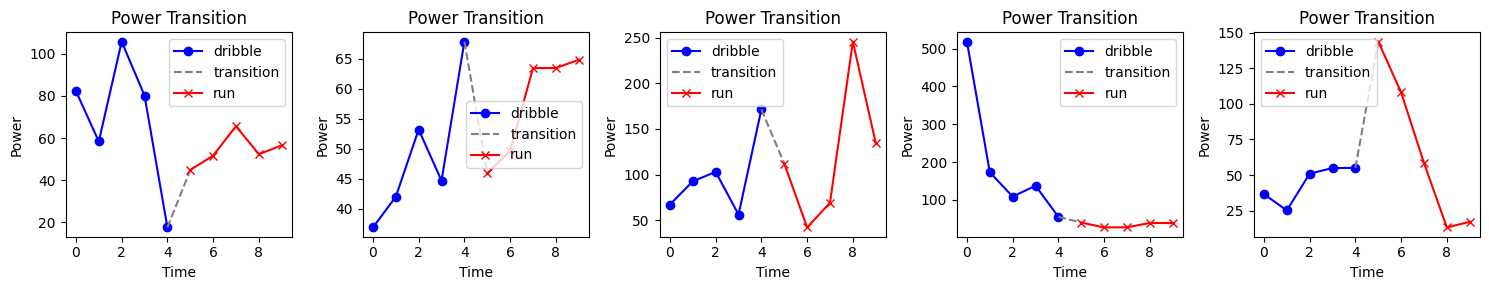

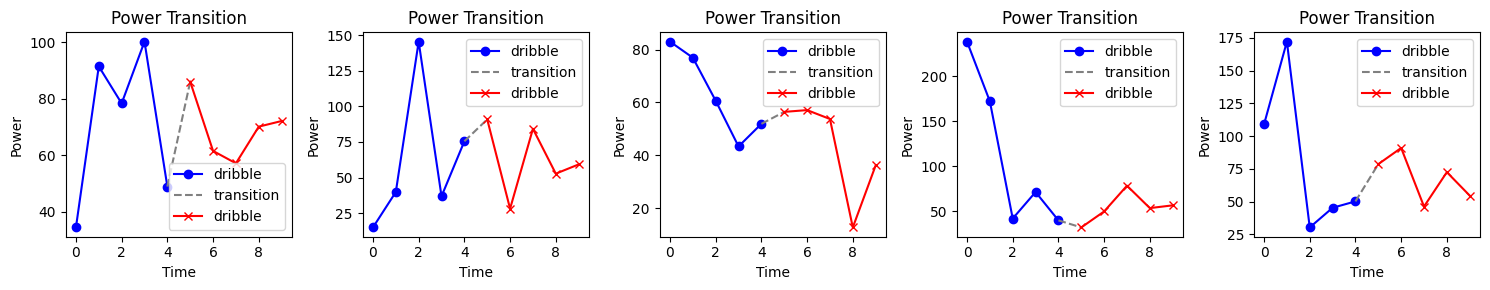

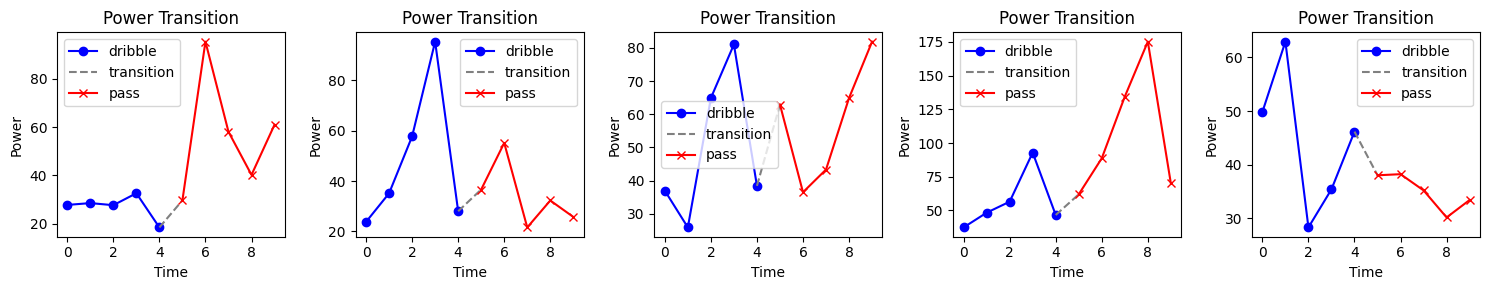

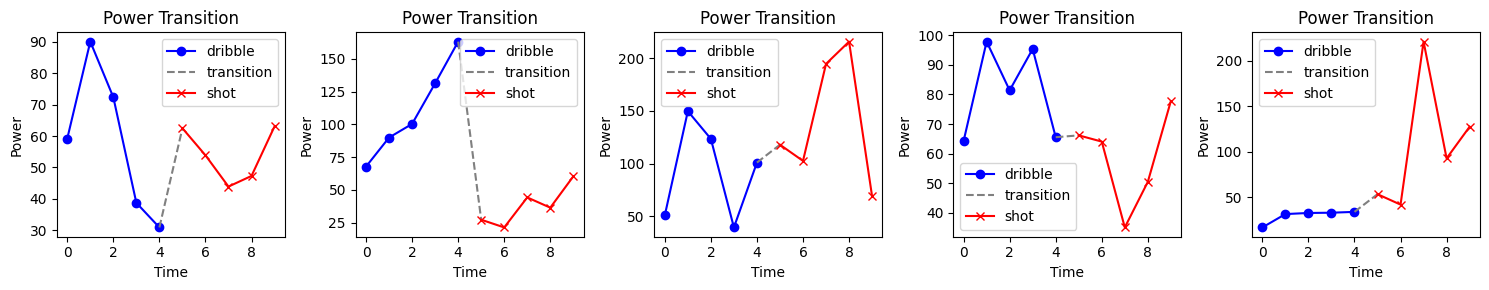

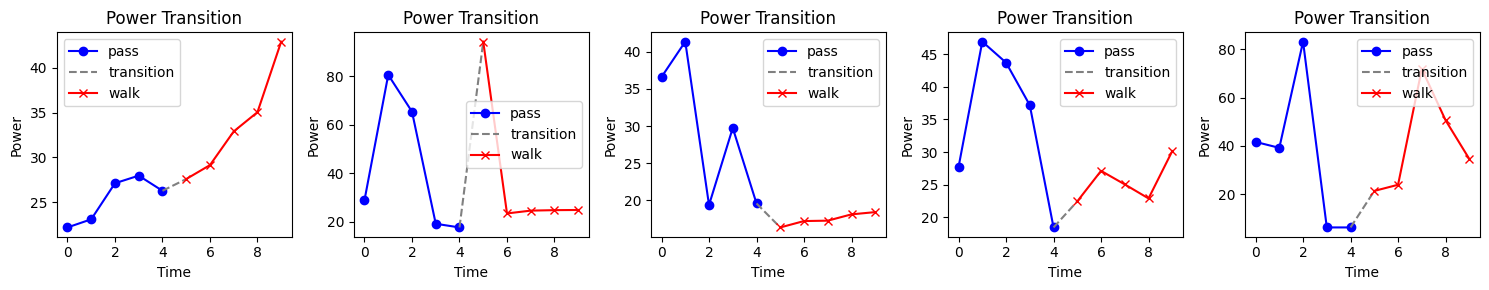

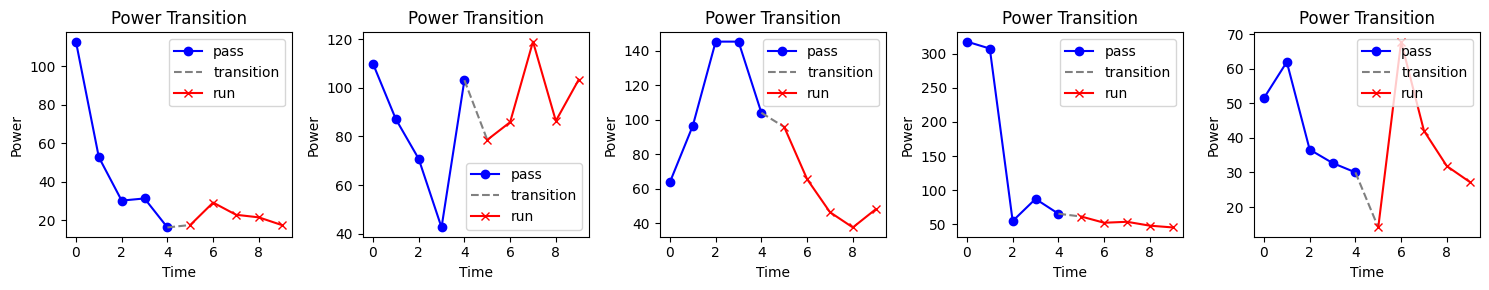

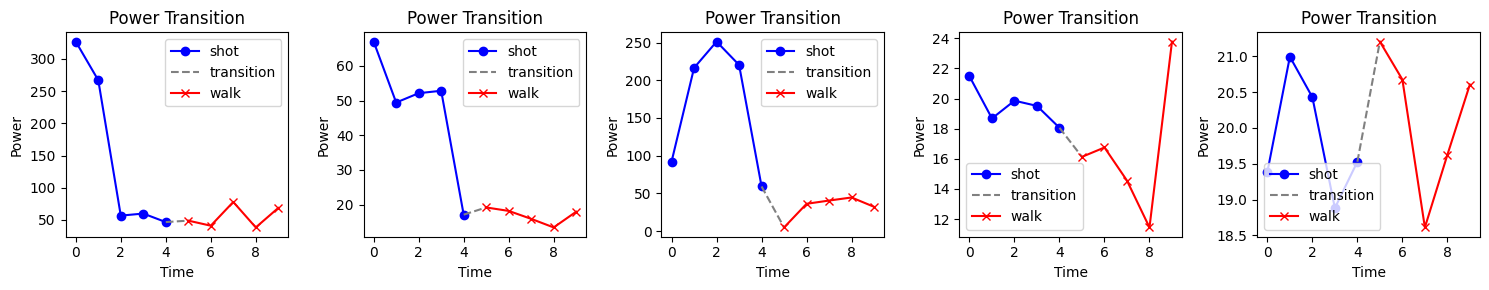

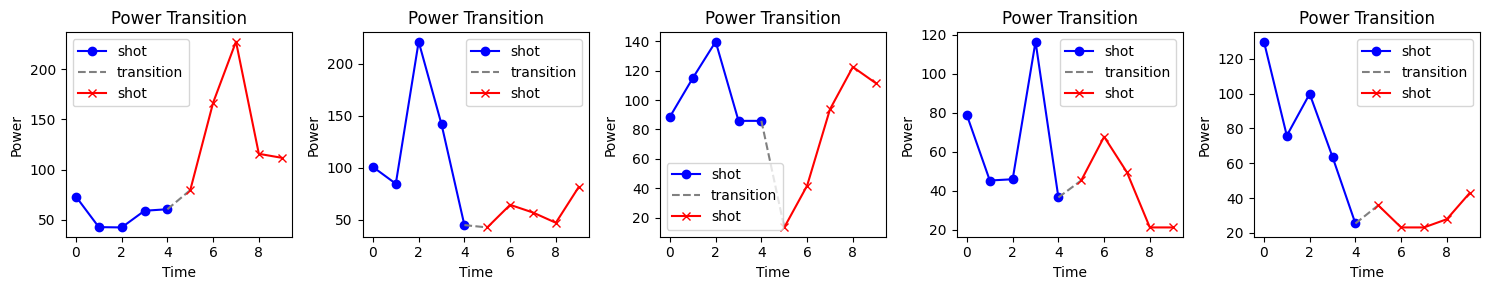

In [16]:
action_indices = {}

for action1 in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot']:
    for action2 in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot']:
        if len(Transi_Game_1[(Transi_Game_1['Action From'] == action1) & (Transi_Game_1['Action To'] == action2)]) >= 5:
            action_indices[(action1, action2)] = np.random.choice(
                Transi_Game_1[(Transi_Game_1['Action From'] == action1) & (Transi_Game_1['Action To'] == action2)].index,
                size=5,
                replace=False
            )

for (action1, action2), indices in action_indices.items():
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    for i, idx in enumerate(indices):
        serie = Transi_Game_1.loc[idx, 'Serie trans']

        axes[i].plot(np.arange(0, 5), serie[:5], color='b', marker='o', linestyle='-', label=action1)
        axes[i].plot(np.arange(4, 6), serie[4:6], color='grey', linestyle='--', label='transition')
        axes[i].plot(np.arange(5, 10), serie[5:], color='r', marker='x', linestyle='-', label=action2)

        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Power')
        axes[i].set_title('Power Transition')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

Transitions seem quite natural, with no significant gaps between two different series.

1. The analysis of our data can be approached from **two distinct** perspectives:
**Single Time Series vs. Multiple Time Series:** We must decide whether to treat the data as a single continuous time series representing the entire game or to segment it into multiple time series, each associated with specific actions. 

2. **Absence of Information:** It's important to acknowledge that we lack information about the roles played by the observed individuals. We cannot ascertain if these individuals are consistent between the two games or if they occupy different positions on the field. Additionally, the absence of 3D positional data hinders our ability to analyze player movements, which is crucial for predicting their actions. Ideally, we would have had access to positional data for all players. Additionaly we are also missing the main event of the game (score effect, change in the squad (either red card or replacement), card effect, strategy used by the coach, weather effect...)

3. **Challenges with Multiple Time Series:** The multi-time series approach faces challenges, primarily due to varying series lengths. While techniques like upsampling and downsampling could be applied to mitigate this issue, the resultant data would be affected by significant variations, impacting the integrity of our analysis.

4. **Simulation** :
 
    -**Label Simulation Methodology:** To simulate game dynamics, we opted for a Monte Carlo Markov Chain approach for action labeling (so the prediction of a label will only be made using the previous label - no history). However, we also considered the use of a "power" matrix to adjust action transitions based on preceding actions, accounting for player fatigue. This approach, though explored, was not integrated into our algorithm. The first analysis of the power approach can be found in the optional part of the notebook.

    -**Norm Simulation:** For simulating norm series corresponding to actions, we randomly selected actions from the available dataset and introduced slight random variations to mimic real-world variability.



# Simulation

## MCMC

In [17]:
labels_game = full_df.label
label_data = {}
# Count occurrences and followed counts
for i in range(len(labels_game) - 1):
    current_label = labels_game[i]
    next_label = labels_game[i + 1]
    
    if current_label not in label_data:
        label_data[current_label] = {'total': 0, 'followed': {}}
    
    label_data[current_label]['total'] += 1
    
    if next_label not in label_data[current_label]['followed']:
        label_data[current_label]['followed'][next_label] = 0
    
    label_data[current_label]['followed'][next_label] += 1




# Convert the nested dictionary into a DataFrame
data_for_df = {}


for label, data in label_data.items():
    percentages = {followed_label: (followed_count / data['total']) if data['total'] > 0 else 0
                for followed_label, followed_count in data['followed'].items()}
    data_for_df[label] = percentages

df_per = pd.DataFrame(data_for_df).fillna(0).T






# Convert transposed DataFrame to tabular format
tabulated_output_1 = tabulate.tabulate(df_per, headers='keys', tablefmt='pretty')

# Print the tabulated output
print(tabulated_output_1)


+-----------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+----------------------+
|           |         walk         |         rest         |         run         |        tackle        |       dribble        |         pass         |         shot         |       no action       |        cross         |
+-----------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+----------------------+
|   walk    |  0.7327188940092166  | 0.06221198156682028  | 0.17050691244239632 | 0.01152073732718894  | 0.018433179723502304 | 0.004608294930875576 |         0.0          |          0.0          |         0.0          |
|   rest    |         0.8          |         0.0          | 0.17142857142857143 |         0.0          |         0.0

In [18]:
# Drop the "no action" row and column
df_per = df_per.drop('no action', axis=0)  # Drop row
df_per = df_per.drop('no action', axis=1)  # Drop column
df_per['walk']['run'] = df_per['walk']['run'] + 0.0018115942028985507
df_per['walk']['shot'] = df_per['walk']['shot'] + 0.05555555555555555

transition_df = df_per

In [19]:
# Create two modified DataFrames with different action probabilities
transition_attacking = transition_df.copy()  # For more "pass," "shot," "dribble," and "run"
transition_defending = transition_df.copy()  # For more "walk," "rest," and "tackle"

# Modify probabilities in the attacking dataframe
transition_attacking['run']['pass'] += 0.15  
transition_attacking['walk']['pass'] += 0.1 
transition_attacking['shot']['pass'] += 0.05 

transition_attacking['run']['run'] += 0.1 
transition_attacking['pass']['run'] += 0.1 
transition_attacking['dribble']['run'] += 0.05 
transition_attacking['shot']['run'] += 0.05 

transition_attacking['run']['dribble'] += 0.1  
transition_attacking['pass']['dribble'] += 0.1  
transition_attacking['shot']['dribble'] += 0.05

# Modify probabilities in the second DataFrame (df2)
transition_defending['walk']['walk'] += 0.1  
transition_defending['run']['walk'] += 0.1 
transition_defending['rest']['walk'] += 0.1   

transition_defending['run']['rest'] += 0.1  
transition_defending['walk']['rest'] += 0.1  

transition_defending['run']['tackle'] += 0.1  
transition_defending['rest']['tackle'] += 0.1
transition_defending['walk']['tackle'] += 0.1    

# Normalize the probabilities in both DataFrames to ensure they sum to 1
transition_attacking = transition_attacking.div(transition_attacking.sum(axis=1), axis=0)
transition_defending = transition_defending.div(transition_defending.sum(axis=1), axis=0)

In [20]:
Time = 90 
# Number of steps in the MCMC simulation
num_steps = int(Time*60*50/np.mean(full_df['longueur']))

# Initial state (replace with the initial label index)
current_state = np.random.choice([0, 1, 2, 5])

# Create an array to store the samples
samples = []

# Perform the MCMC simulation
for _ in range(num_steps):
    # Propose a new state based on the transition probabilities
    proposed_state = np.random.choice(len(df_per), p=df_per.iloc[current_state])  ##CHANGE df_per by transition_attacking / transition_defendng to change the type of the game
    
    # Move to the proposed state
    current_state = proposed_state
    
    # Store the current state as a sample
    samples.append(current_state)

# Convert label indices to actual labels
label_mapping = ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'shot', 'cross']
sampled_labels = [label_mapping[state] for state in samples]

# Print the sampled labels
print("Sampled labels:", sampled_labels)

Sampled labels: ['walk', 'walk', 'walk', 'walk', 'rest', 'walk', 'walk', 'walk', 'walk', 'run', 'run', 'walk', 'pass', 'walk', 'rest', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'walk', 'walk', 'walk', 'walk', 'run', 'run', 'walk', 'rest', 'walk', 'walk', 'walk', 'walk', 'run', 'walk', 'walk', 'walk', 'rest', 'walk', 'walk', 'walk', 'walk', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'rest', 'walk', 'rest', 'run', 'run', 'run', 'run', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'run', 'run', 'run', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'run', 'run', 'tackle', 'run', 'run', 'tackle', 'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'rest', 'walk', 'wal

## Serie Simulation

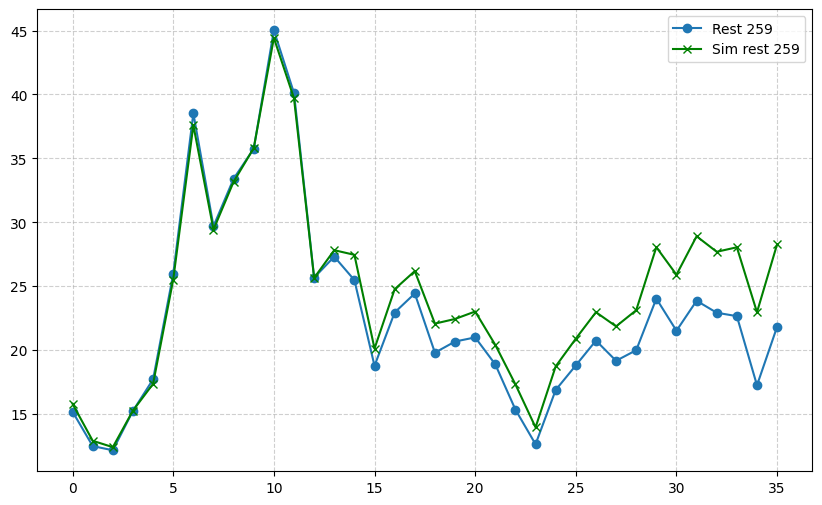

In [21]:
#Test to see the difference between 1 serie modified and the official serie
noise_std_walk = actions['rest']['std']*0.1
serie_test = df[df['label']=='rest']['norm'][259]
# Add normally distributed noise to the data
random_steps = np.random.normal(loc=0, scale=noise_std_walk, size=len(serie_test))

noisy_data_walk_test = serie_test + np.cumsum(random_steps)
small_positive_constant = 0.05*max(serie_test) 
negative_indices = np.where(noisy_data_walk_test < 5)
noisy_data_walk_test[negative_indices] += small_positive_constant

fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(range(len(serie_test)), serie_test, marker='o', linestyle='-', label='Rest 259')
ax.plot(range(len(noisy_data_walk_test)), noisy_data_walk_test, marker='x', linestyle='-', color='g', label='Sim rest 259')


# Add grid lines
ax.grid(True, linestyle='--', alpha=0.6)

# Add a legend
ax.legend()

plt.show()


Since we are picking random series, we add some transition point at the end of each serie equal to +-10% the 1st element of the next serie

# Please now use the Simulations.py to generate as many games as you want.

---------------------------------------------------------------------------------------

## Optional

### Power analysis

To get a better understanding of the actions and their appearence in a game it seems interesting to have a look from a power perspective. We can see in the data that some actions are highly consumming energy (shot, pass, tackle) while some others are there to help the player get it's energy back (rest/walk). I want to understand the frequency of those action during a game

In [22]:
Valeur_effort = 29
Nombre_action_seconde = 50

Puissance_seconde_1 = [
    sum(Full_data_1[i:i + Nombre_action_seconde])
    for i in range(0, len(Full_data_1) - Nombre_action_seconde  + 1, Nombre_action_seconde )
]

Puissance_seconde_2 = [
    sum(Full_data_2[i:i + Nombre_action_seconde])
    for i in range(0, len(Full_data_2) - Nombre_action_seconde  + 1, Nombre_action_seconde )
]

We take 29 as the value for the accelerometer where the player is resting (95% of the data for rest is below this value). Meaning that every action with a power above 29*50 per second (because we have 50 measures per seconds) will result in a decrease of energy for the player while everything below will help him recover

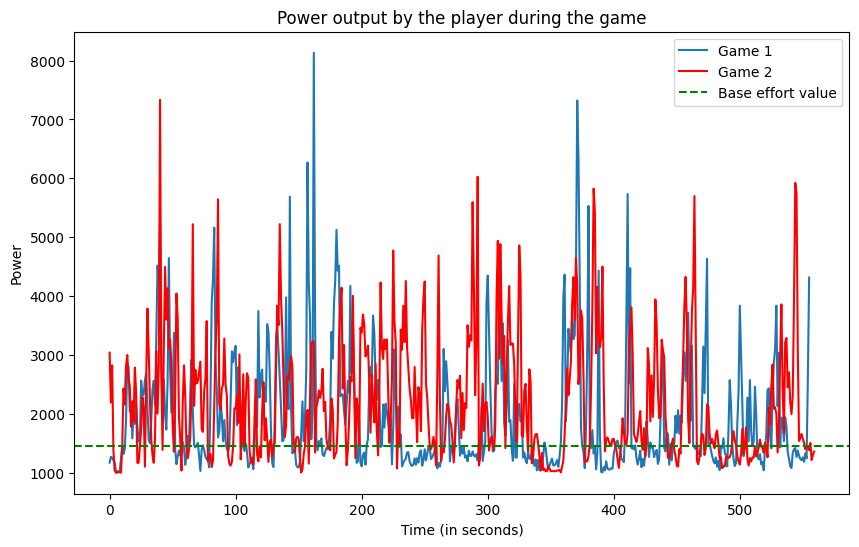

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(Puissance_seconde_1)), Puissance_seconde_1, label = 'Game 1')
plt.plot(range(len(Puissance_seconde_2)), Puissance_seconde_2, color='r', label = 'Game 2')
plt.axhline(y=Valeur_effort*Nombre_action_seconde, color='g', linestyle='--', label='Base effort value')

plt.xlabel('Time (in seconds)')
plt.ylabel('Power')
plt.title('Power output by the player during the game')
plt.legend()
plt.show()

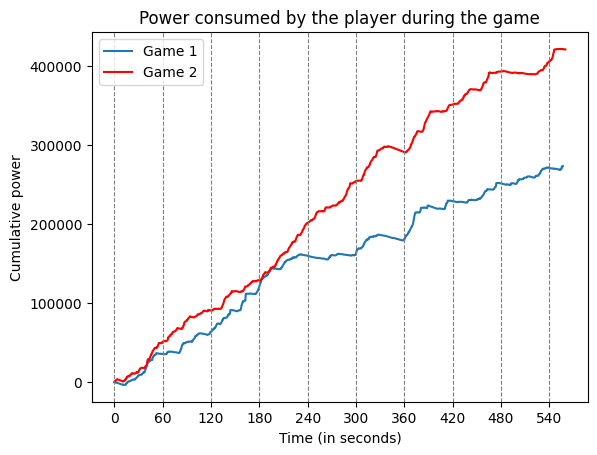

In [24]:
data_subtracted_1 = Full_data_1 - 29
data_subtracted_2 = Full_data_2 - 29

# Calculate the cumulative sum of the subtracted series
cumulative_data_1 = data_subtracted_1.cumsum()
cumulative_data_2 = data_subtracted_2.cumsum()

# Plot the cumulative data
plt.plot(cumulative_data_1, label='Game 1')
plt.plot(cumulative_data_2, color='r', label='Game 2')
plt.xlabel('Time (in seconds)')
plt.ylabel('Cumulative power')
plt.title('Power consumed by the player during the game')

# Customize x-axis ticks
plt.xticks(range(0, len(cumulative_data_2), 60 * 50), [str(i) for i in range(0, int(len(cumulative_data_2) / 50), 60)])

# Add vertical lines
for x in range(0, len(cumulative_data_2), 60 * 50):
    plt.axvline(x=x, linestyle='--', color='grey', linewidth=0.8)

# Add a legend
plt.legend()

plt.show()

We can see that the power output is really different between the 2 games. This can be used a factor to play with the intensity when we will generate our own games

GAME 1
-------
Minute 1: Power output = 35936.46448818967
Minute 2: Power output = 28188.145047033595
Minute 3: Power output = 56927.774662357035
Minute 4: Power output = 39094.37047100841
Minute 5: Power output = 3253.93942571741
Minute 6: Power output = 17029.57685915574
Minute 7: Power output = 48974.012028525714
Minute 8: Power output = 22563.03142891843
Minute 9: Power output = 19721.014146335034
Maximal power output for Game 1: 271688.328557241


GAME 2
-------
Minute 1: Power output = 51444.24550164738
Minute 2: Power output = 39589.49516204849
Minute 3: Power output = 37935.99226543176
Minute 4: Power output = 72933.97889115413
Minute 5: Power output = 52878.339059600796
Minute 6: Power output = 36579.37692854202
Minute 7: Power output = 60263.454628571955
Minute 8: Power output = 42071.05410199185
Minute 9: Power output = 12822.375477307107
Maximal power output for Game 2: 406518.31201629556




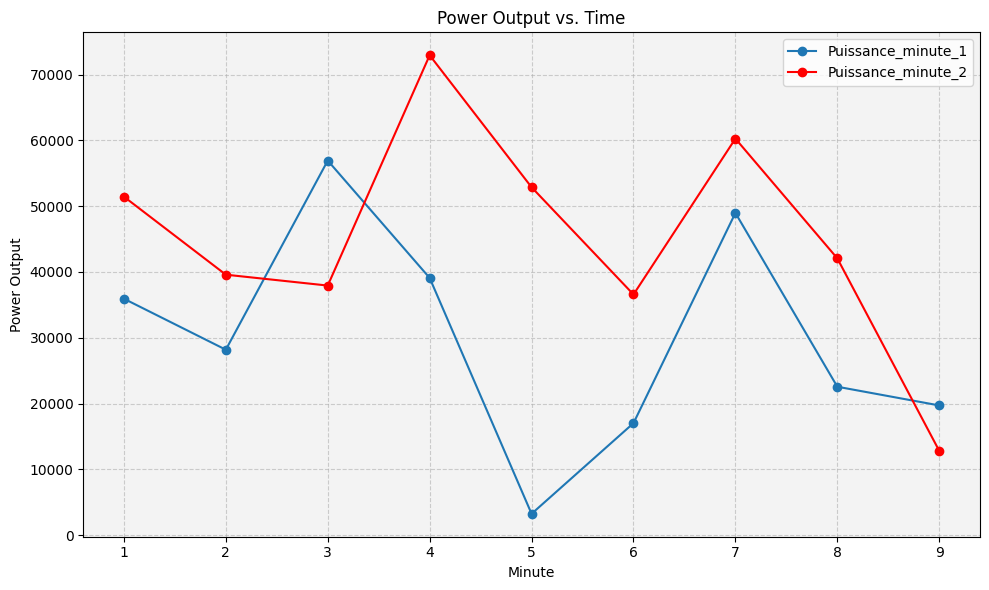

In [25]:
Puissance_recup = 0
Puissance_effort = 0
Puissance_minute_1 = []
t = 0
minute_power = 0  # Initialize power for the current minute


print("GAME 1")
print("-------")
for i in range(len(Puissance_seconde_1)):
    if Puissance_seconde_1[i] <= Nombre_action_seconde * Valeur_effort:
        Puissance_recup = Puissance_recup + ((Nombre_action_seconde * Valeur_effort) - Puissance_seconde_1[i])
    else:
        Puissance_effort = Puissance_effort + (Puissance_seconde_1[i] - (Nombre_action_seconde * Valeur_effort))

    if (i + 1) % 60 == 0:  # Check if a minute has passed (assuming 60 data points per minute)
        t += 1
        Puissance_max_1 = Puissance_effort - Puissance_recup


        Puissance_minute_1.append(Puissance_max_1)

        # Reset power values for the next minute
        Puissance_recup = 0
        Puissance_effort = 0

# Print the power output for each minute
for minute, power in enumerate(Puissance_minute_1, start=1):
    print(f"Minute {minute}: Power output = {power}")

# Print the maximal power output for the entire game
print("Maximal power output for Game 1:", sum(Puissance_minute_1))
print('\n')

Puissance_recup = 0
Puissance_effort = 0
Puissance_minute_2 = []
t = 0
minute_power = 0  # Initialize power for the current minute


print("GAME 2")
print("-------")
for i in range(len(Puissance_seconde_2)):
    if Puissance_seconde_2[i] <= Nombre_action_seconde * Valeur_effort:
        Puissance_recup = Puissance_recup + ((Nombre_action_seconde * Valeur_effort) - Puissance_seconde_2[i])
    else:
        Puissance_effort = Puissance_effort + (Puissance_seconde_2[i] - (Nombre_action_seconde * Valeur_effort))

    if (i + 1) % 60 == 0:  # Check if a minute has passed (assuming 60 data points per minute)
        t += 1
        Puissance_max_2 = Puissance_effort - Puissance_recup


        Puissance_minute_2.append(Puissance_max_2)

        # Reset power values for the next minute
        Puissance_recup = 0
        Puissance_effort = 0

# Print the power output for each minute
for minute, power in enumerate(Puissance_minute_2, start=1):
    print(f"Minute {minute}: Power output = {power}")

# Print the maximal power output for the entire game
print("Maximal power output for Game 2:", sum(Puissance_minute_2))
print('\n')


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create x-axis values from 1 to 9 (instead of 0 to 8)
x_values = np.arange(1, 10)

# Plot Puissance_minute_1 as a line plot with blue color and label
ax.plot(x_values, Puissance_minute_1, marker='o', linestyle='-', label='Puissance_minute_1')

# Plot Puissance_minute_2 as a line plot with red color and label
ax.plot(x_values, Puissance_minute_2, marker='o', linestyle='-', color='r', label='Puissance_minute_2')

# Set x-axis ticks and labels
ax.set_xticks(x_values)
ax.set_xticklabels(x_values)

# Set axis labels and a title
ax.set_xlabel('Minute')
ax.set_ylabel('Power Output')
ax.set_title('Power Output vs. Time')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.6)

# Add a legend
ax.legend()

# Customize the appearance (optional)
ax.set_facecolor('#f3f3f3')
plt.rcParams['axes.edgecolor'] = '#333F4B'
plt.rcParams['axes.linewidth'] = 0.8

# Show the plot
plt.tight_layout()
plt.show()

### Full Graph of the 2 games

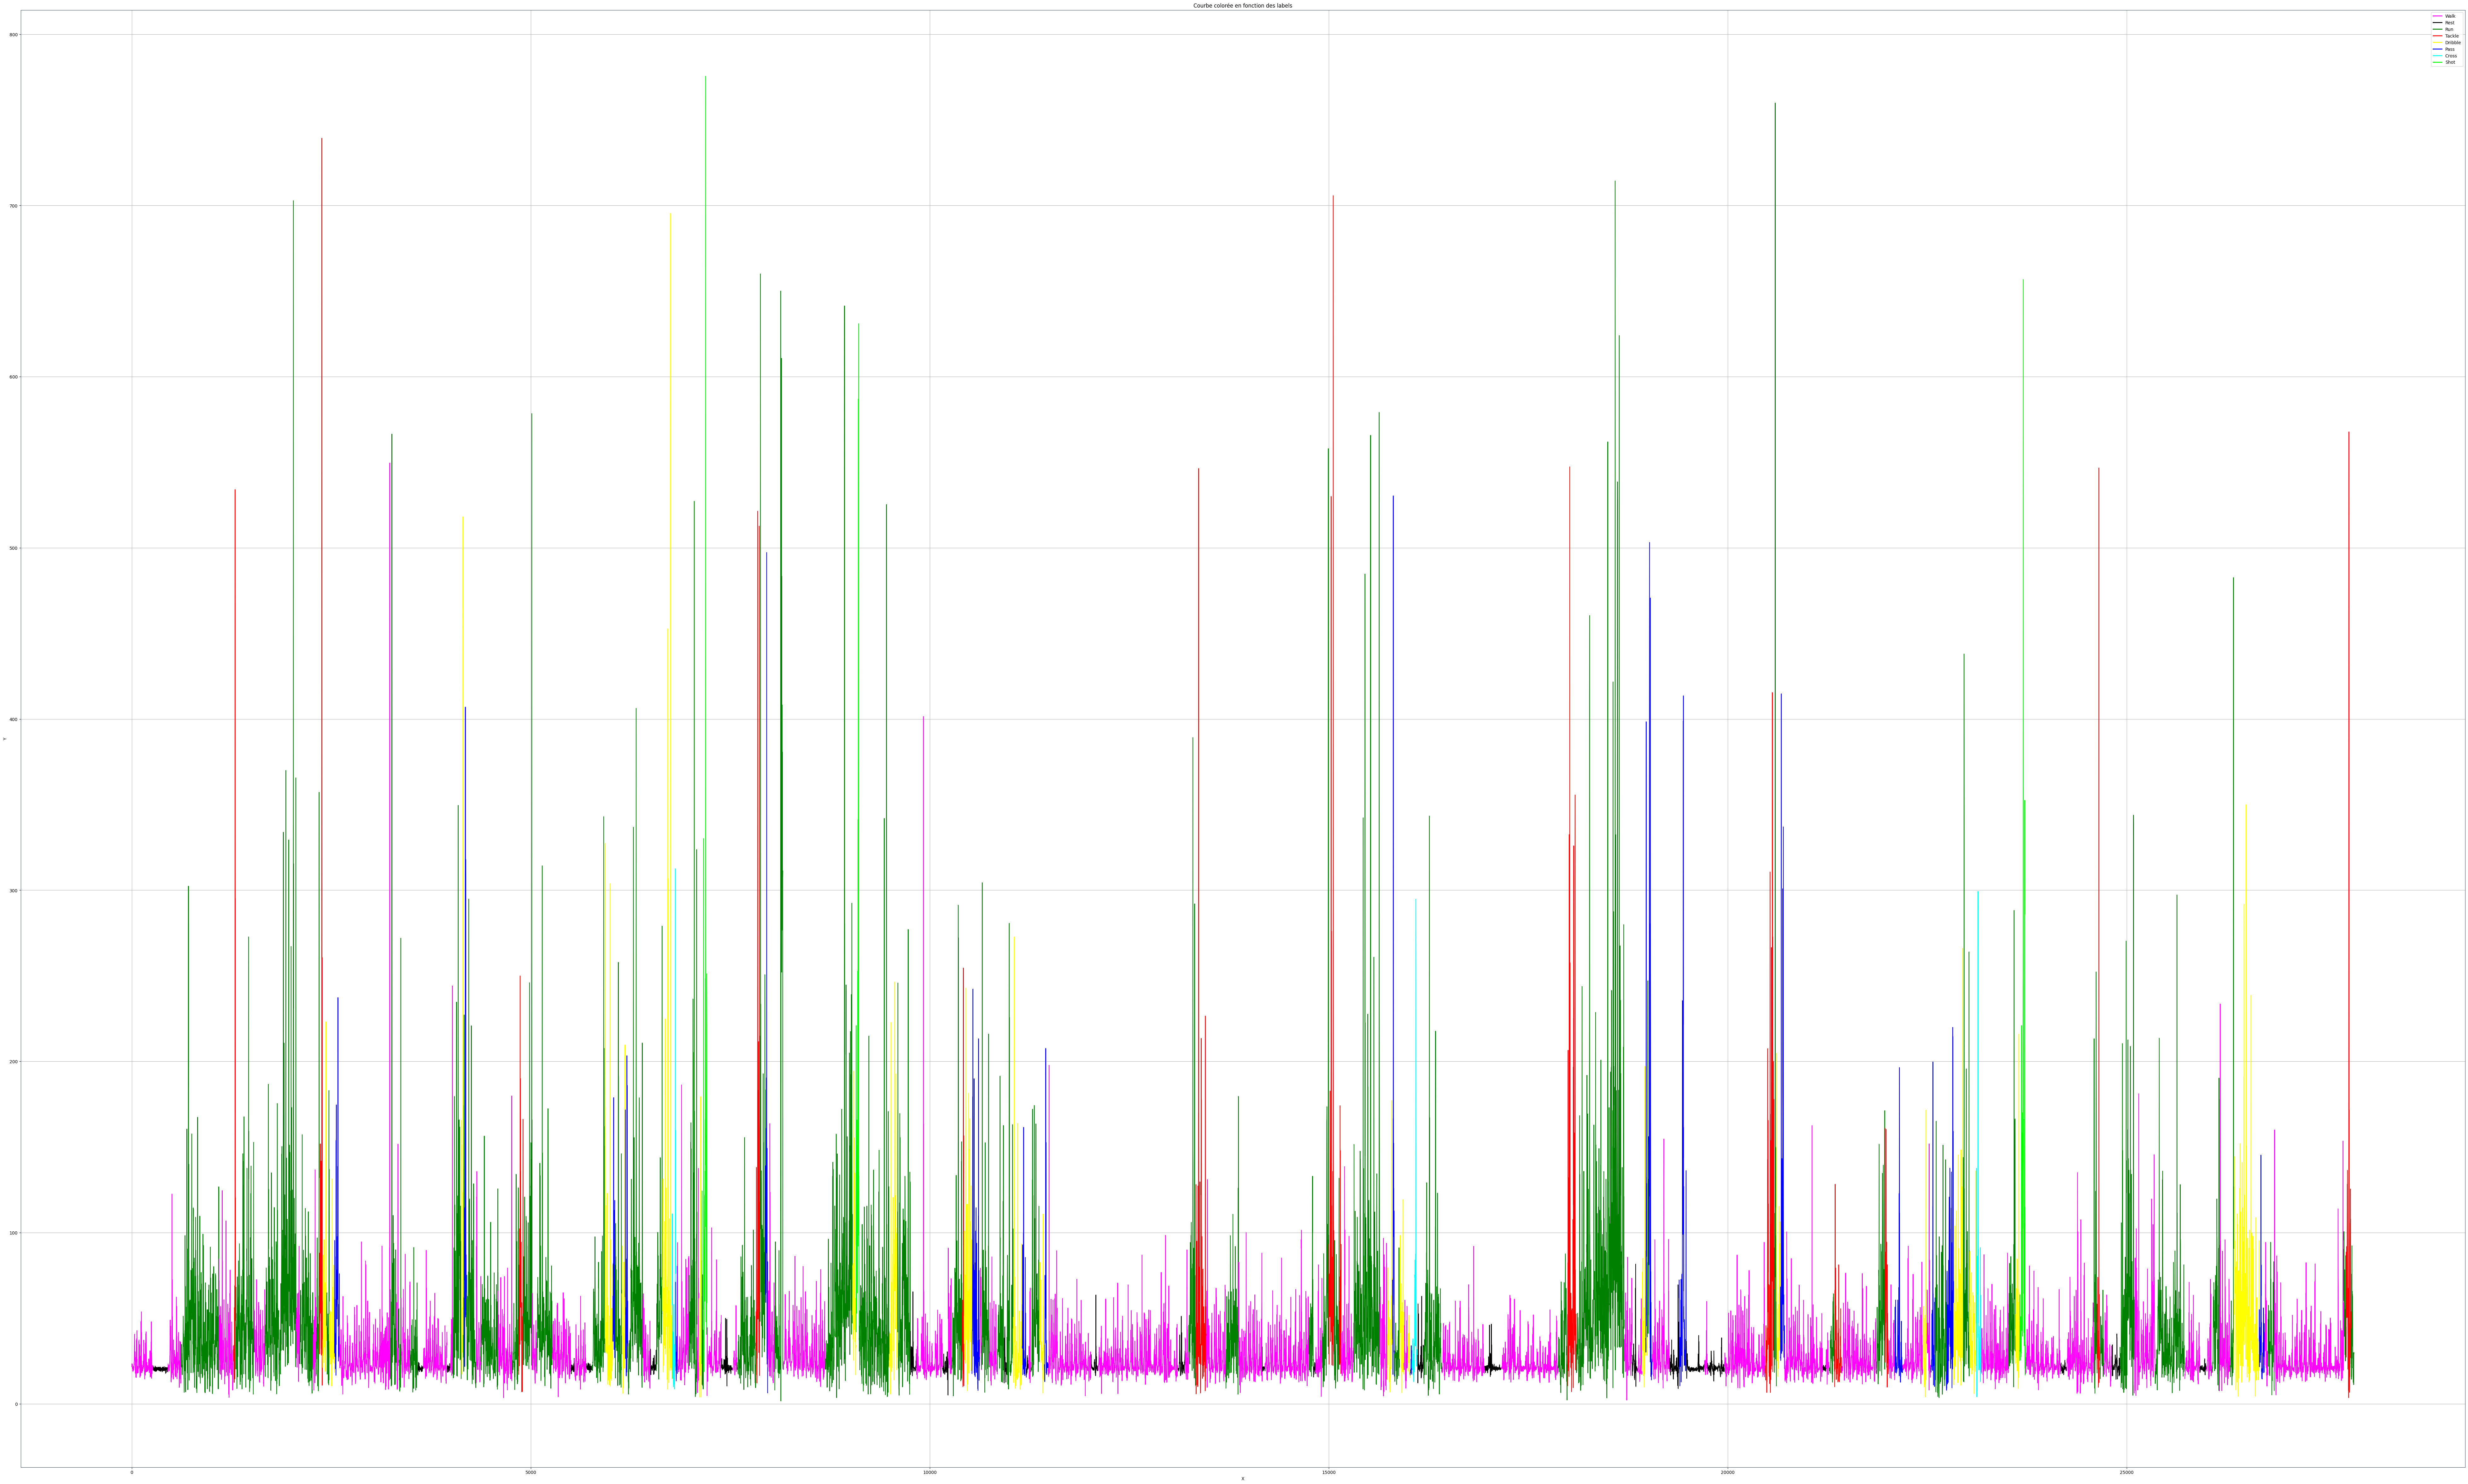

In [26]:
x = Game_1.index
y = Game_1['norm']
labels = Game_1['label']

# Création de la figure et du graphe
plt.figure(figsize=(100, 60))

# Définition des couleurs correspondantes aux labels
colors = ['fuchsia', 'black', 'green', 'red', 'yellow', 'blue', 'cyan', 'lime', 'silver']

# Tracer la courbe en colorant en fonction des labels
current_label = labels[0]
current_segment_start = 0

for i in range(1, len(x)):
    if labels[i] != current_label:
        plt.plot(x[current_segment_start:i], y[current_segment_start:i], color=colors[current_label], label=f'Label {current_label}')
        current_label = labels[i]
        current_segment_start = i

legend_elements = [
    Line2D([0], [0], color='fuchsia', lw=2, label='Walk'),
    Line2D([0], [0], color='black', lw=2, label='Rest'),
    Line2D([0], [0], color='green', lw=2, label='Run'),
    Line2D([0], [0], color='red', lw=2, label='Tackle'),
    Line2D([0], [0], color='yellow', lw=2, label='Dribble'),
    Line2D([0], [0], color='blue', lw=2, label='Pass'),
    Line2D([0], [0], color='cyan', lw=2, label='Cross'),
    Line2D([0], [0], color='lime', lw=2, label='Shot'),
]

# Tracer le dernier segment
plt.plot(x[current_segment_start:], y[current_segment_start:], color=colors[current_label], label=f'Label {current_label}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Courbe colorée en fonction des labels')
plt.legend(handles=legend_elements)
plt.grid(True)
plt.show()

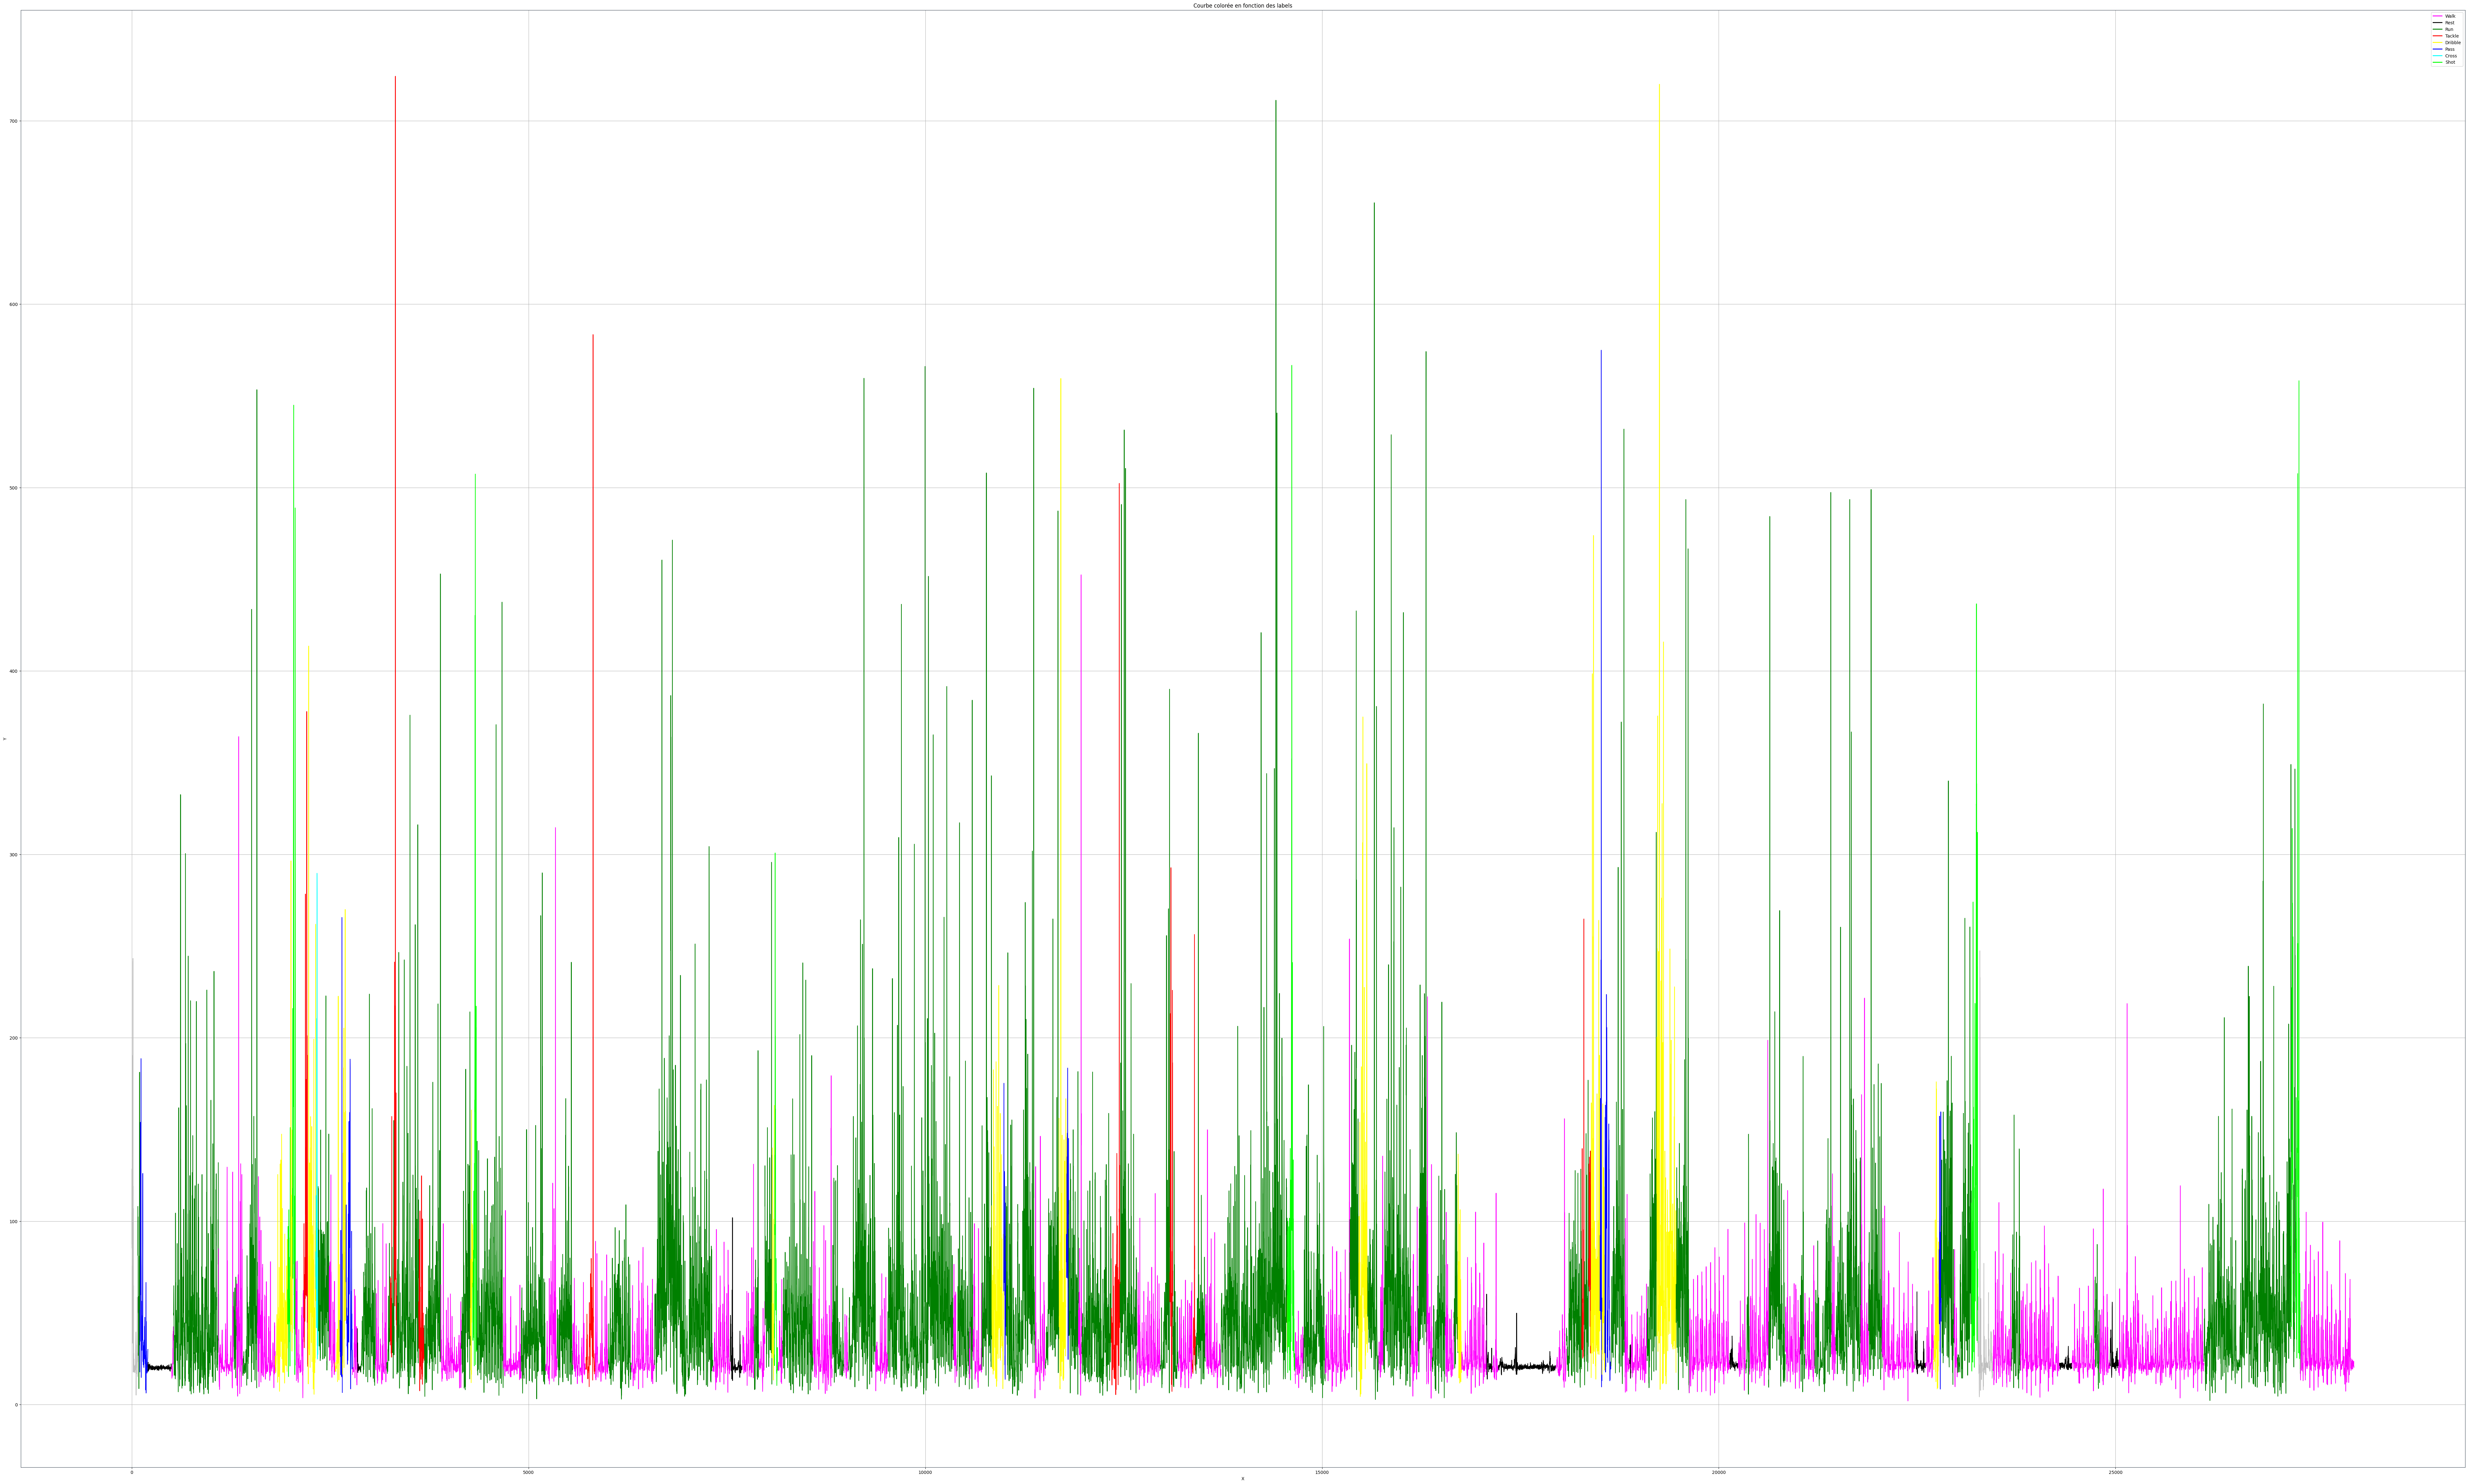

In [27]:
x = Game_2.index
y = Game_2['norm']
labels = Game_2['label']

# Création de la figure et du graphe
plt.figure(figsize=(100, 60))

# Définition des couleurs correspondantes aux labels
colors = ['fuchsia', 'black', 'green', 'red', 'yellow', 'blue', 'cyan', 'lime', 'silver']

# Tracer la courbe en colorant en fonction des labels
current_label = labels[0]
current_segment_start = 0

for i in range(1, len(x)):
    if labels[i] != current_label:
        plt.plot(x[current_segment_start:i], y[current_segment_start:i], color=colors[current_label], label=f'Label {current_label}')
        current_label = labels[i]
        current_segment_start = i

legend_elements = [
    Line2D([0], [0], color='fuchsia', lw=2, label='Walk'),
    Line2D([0], [0], color='black', lw=2, label='Rest'),
    Line2D([0], [0], color='green', lw=2, label='Run'),
    Line2D([0], [0], color='red', lw=2, label='Tackle'),
    Line2D([0], [0], color='yellow', lw=2, label='Dribble'),
    Line2D([0], [0], color='blue', lw=2, label='Pass'),
    Line2D([0], [0], color='cyan', lw=2, label='Cross'),
    Line2D([0], [0], color='lime', lw=2, label='Shot'),
]

# Tracer le dernier segment
plt.plot(x[current_segment_start:], y[current_segment_start:], color=colors[current_label], label=f'Label {current_label}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Courbe colorée en fonction des labels')
plt.legend(handles=legend_elements)
plt.grid(True)
plt.show()

### Other Functions

In [28]:
def find_max_position(series):
    max_value = max(series)
    max_position = series.index(max_value)
    return max_position

def find_max_proportion(series):
    max_proportion = series.index(max(series))/len(series)
    return max_proportion

In [29]:
for label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot']:

    pos_max = full_df[full_df['label']==label]['norm'].apply(lambda x : find_max_position(x))
    prop_max = full_df[full_df['label']==label]['norm'].apply(lambda x : find_max_proportion(x))

    mean, median, std, percentile_95, max_val, min_val = calculate_statistics(prop_max)

    print("STATISTICS FOR THE ACTION : ", label)
    print("Mean:", mean)
    print("Median:", median)
    print("Standard Deviation:", std)
    print("95th Percentile:", percentile_95)
    print("Max :", max_val)
    print("Min :", min_val)
    print("--------------------")

STATISTICS FOR THE ACTION :  walk
Mean: 0.6169600852593682
Median: 0.671875
Standard Deviation: 0.2274182561852029
95th Percentile: 0.9090909090909091
Max : 0.9861111111111112
Min : 0.0
--------------------
STATISTICS FOR THE ACTION :  rest
Mean: 0.4587779982926146
Median: 0.4189189189189189
Standard Deviation: 0.3063166892780857
95th Percentile: 0.8691570881226054
Max : 0.95
Min : 0.0
--------------------
STATISTICS FOR THE ACTION :  run
Mean: 0.6185916209878667
Median: 0.719375
Standard Deviation: 0.274145306838321
95th Percentile: 0.9285714285714286
Max : 0.9833333333333333
Min : 0.0
--------------------
STATISTICS FOR THE ACTION :  tackle
Mean: 0.646018512094355
Median: 0.6923076923076923
Standard Deviation: 0.22209944674799062
95th Percentile: 0.8965909090909091
Max : 0.9230769230769231
Min : 0.043478260869565216
--------------------
STATISTICS FOR THE ACTION :  dribble
Mean: 0.5904038252726083
Median: 0.6927083333333333
Standard Deviation: 0.3025204981259003
95th Percentile: 0.93

In [30]:
def calculate_series_lengths(index):
    """
    function to get the indices where a serie end in a dataframe with only 1 type of action
    
    """
    series_lengths = []
    current_length = 1  # Initialize the length of the current series
    
    for i in range(1, len(index)):
        if index[i] == index[i - 1] + 1:
            # Numbers follow each other in the series
            current_length += 1
        else:
            # Numbers don't follow each other; start a new series
            if current_length > 1:
                if len(series_lengths)==0:
                     series_lengths.append(current_length)
                else:
                    series_lengths.append(current_length+series_lengths[-1])
            current_length = 1  # Reset the length for the new series
    
    # Append the length of the last series if it exists
    if current_length > 1:
        series_lengths.append(current_length+series_lengths[-1])
    
    return pd.Series(series_lengths)

### Some histograms

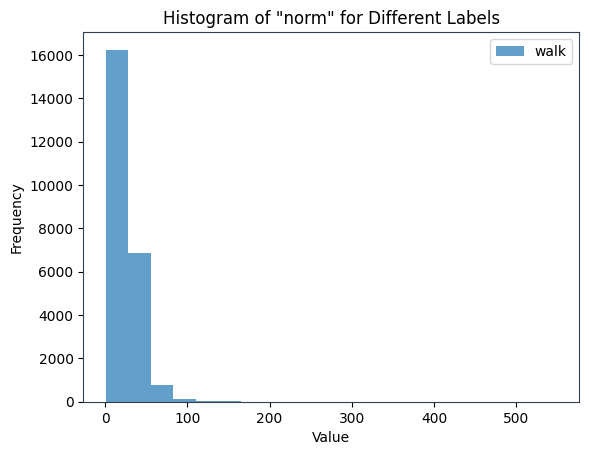

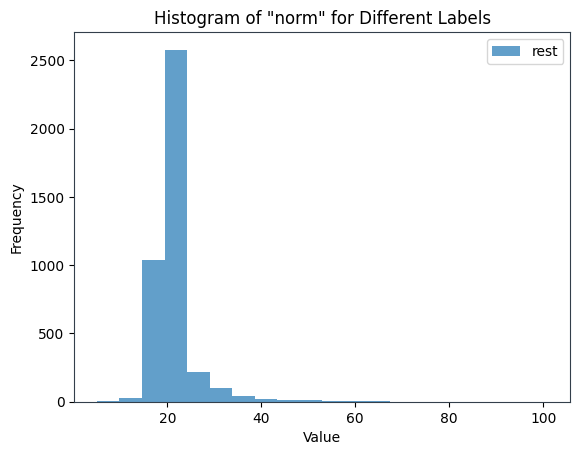

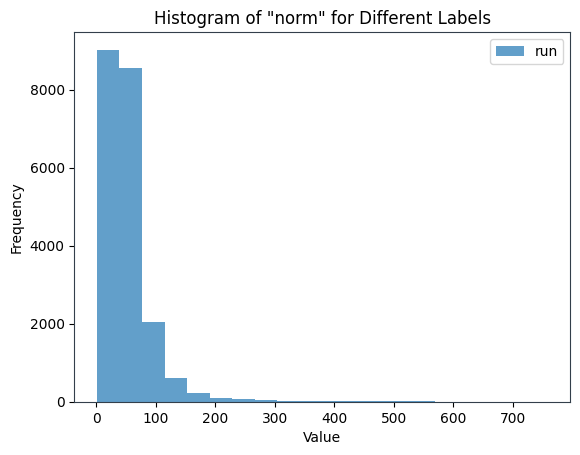

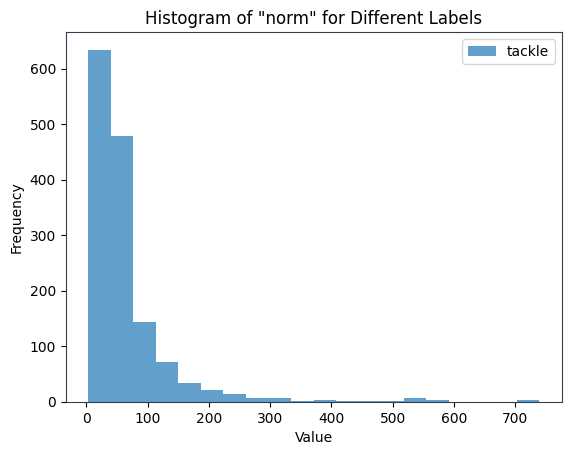

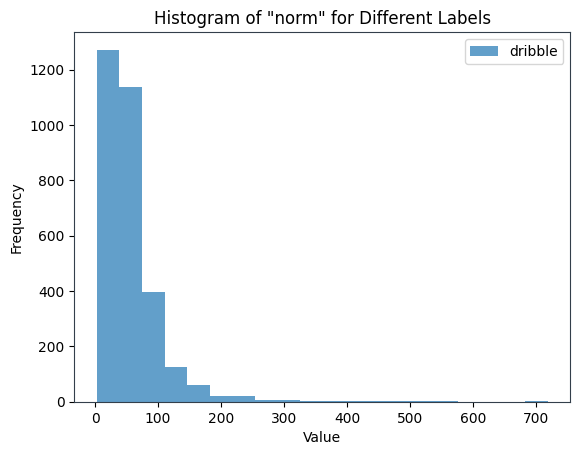

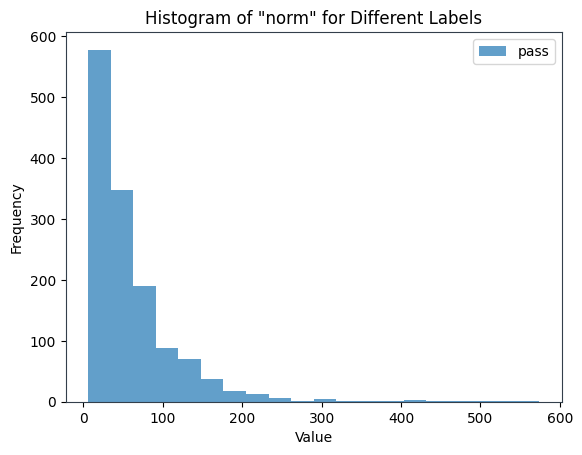

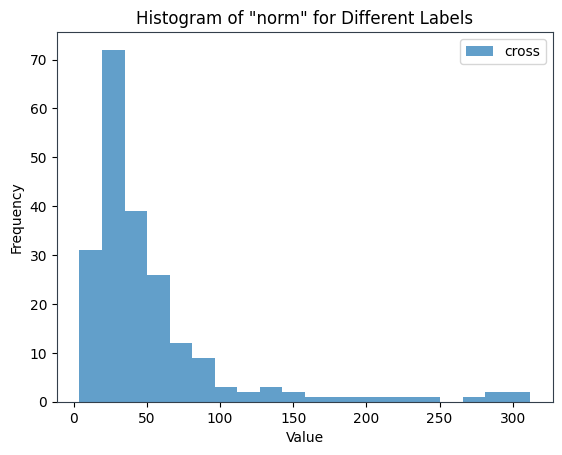

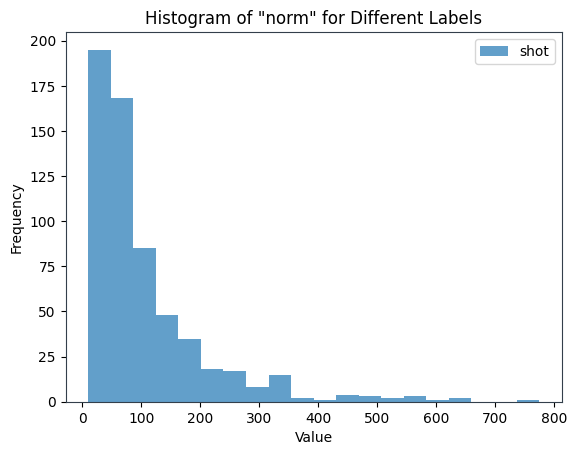

In [31]:
for label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot']:
    data = full_df[full_df['label'] == label]['norm'].explode().apply(lambda x: int(x))
    
    # Plot a histogram
    plt.hist(data, bins=20, alpha=0.7, label=label)  # Adjust the number of bins as needed

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Histogram of "norm" for Different Labels')
    plt.show()

### Some similarity measure for series with different length

In [33]:
# Select two actions for DTW comparison
action1 = 'walk'
action2 = 'rest'

dtw_distances = []

subset_action1 = df[df['label'] == action1]['norm']
#len(subset_action1)
for i in range(15):
    dtw_row = []
    for j in range(15):
        dtw_distance, _ = fastdtw(subset_action1.iloc[i], subset_action1.iloc[j])
        dtw_row.append(dtw_distance)
    dtw_distances.append(dtw_row)

# Convert the DTW distances to a DataFrame
dtw_distance_df = pd.DataFrame(dtw_distances, index=range(1, 15+1),
                                columns=range(1, 15+1))

print(dtw_distance_df)


            1           2           3           4           5           6   \
1     0.000000  165.141459  140.721108  317.457134  377.904423  331.612902   
2   165.141459    0.000000  326.713116  363.144490  375.729618  346.627840   
3   140.721108  326.713116    0.000000  155.147477  466.697324  369.323323   
4   317.457134  363.144490  155.147477    0.000000  412.208803  473.876030   
5   377.904423  375.729618  466.697324  412.208803    0.000000  455.244206   
6   331.612902  346.627840  369.323323  473.876030  455.244206    0.000000   
7   249.515526  302.448774  308.805062  390.321880  374.337702  298.938317   
8   691.341715  611.074419  734.913194  838.989325  690.656669  598.074001   
9   313.754060  347.105328  324.771295  548.015391  380.439646  497.466344   
10  366.624000  378.688404  613.523389  589.789224  304.518689  463.216778   
11  243.628586  269.246794  244.827305  276.430752  276.005308  332.681939   
12  473.169696  442.067258  529.834354  483.498128  678.402071  

In [34]:
print(dtw_distance_df/(dtw_distance_df.max().max()))

          1         2         3         4         5         6         7   \
1   0.000000  0.167023  0.142325  0.321074  0.382211  0.335392  0.252359   
2   0.167023  0.000000  0.330436  0.367282  0.380011  0.350578  0.305895   
3   0.142325  0.330436  0.000000  0.156915  0.472015  0.373532  0.312324   
4   0.321074  0.367282  0.156915  0.000000  0.416906  0.479276  0.394769   
5   0.382211  0.380011  0.472015  0.416906  0.000000  0.460432  0.378603   
6   0.335392  0.350578  0.373532  0.479276  0.460432  0.000000  0.302345   
7   0.252359  0.305895  0.312324  0.394769  0.378603  0.302345  0.000000   
8   0.699219  0.618037  0.743287  0.848549  0.698526  0.604889  0.573323   
9   0.317329  0.351060  0.328472  0.554260  0.384775  0.503135  0.388935   
10  0.370802  0.383003  0.620514  0.596510  0.307989  0.468495  0.428687   
11  0.246405  0.272315  0.247617  0.279581  0.279150  0.336473  0.200855   
12  0.478561  0.447104  0.535872  0.489007  0.686132  0.335321  0.401102   
13  0.274843

### Tool to plot your own graph of the generated serie

In [35]:
"""
dfde=pd.read_json("GamesGenerated\Game_'Defending'_0.json") #Change the name of json file you want to read

Game_def = dfde.explode('norm')[['label','norm']].reset_index(drop=True)
label_mapping = {'walk': 0, 'rest': 1, 'run': 2, 'tackle': 3, 'dribble': 4, 'pass': 5, 'cross': 6, 'shot': 7, 'no action': 8}
# Convert string labels to integers using list comprehension
Game_def['label'] = [label_mapping[label] for label in Game_def['label']]

x = Game_def.index
y = Game_def['norm']
labels = Game_def['label']

# Création de la figure et du graphe
plt.figure(figsize=(100, 60))

# Définition des couleurs correspondantes aux labels
colors = ['fuchsia', 'black', 'green', 'red', 'yellow', 'blue', 'cyan', 'lime', 'silver']

# Tracer la courbe en colorant en fonction des labels
current_label = labels[0]
current_segment_start = 0

for i in range(1, len(x)):
    if labels[i] != current_label:
        plt.plot(x[current_segment_start:i], y[current_segment_start:i], color=colors[current_label], label=f'Label {current_label}')
        current_label = labels[i]
        current_segment_start = i

legend_elements = [
    Line2D([0], [0], color='fuchsia', lw=2, label='Walk'),
    Line2D([0], [0], color='black', lw=2, label='Rest'),
    Line2D([0], [0], color='green', lw=2, label='Run'),
    Line2D([0], [0], color='red', lw=2, label='Tackle'),
    Line2D([0], [0], color='yellow', lw=2, label='Dribble'),
    Line2D([0], [0], color='blue', lw=2, label='Pass'),
    Line2D([0], [0], color='cyan', lw=2, label='Cross'),
    Line2D([0], [0], color='lime', lw=2, label='Shot'),
]

# Tracer le dernier segment
plt.plot(x[current_segment_start:], y[current_segment_start:], color=colors[current_label], label=f'Label {current_label}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Courbe colorée en fonction des labels')
plt.legend(handles=legend_elements)
plt.grid(True)
plt.show()
"""

'\ndfde=pd.read_json("GamesGenerated\\Game_\'Defending\'_0.json") #Change the name of json file you want to read\n\nGame_def = dfde.explode(\'norm\')[[\'label\',\'norm\']].reset_index(drop=True)\nlabel_mapping = {\'walk\': 0, \'rest\': 1, \'run\': 2, \'tackle\': 3, \'dribble\': 4, \'pass\': 5, \'cross\': 6, \'shot\': 7, \'no action\': 8}\n# Convert string labels to integers using list comprehension\nGame_def[\'label\'] = [label_mapping[label] for label in Game_def[\'label\']]\n\nx = Game_def.index\ny = Game_def[\'norm\']\nlabels = Game_def[\'label\']\n\n# Création de la figure et du graphe\nplt.figure(figsize=(100, 60))\n\n# Définition des couleurs correspondantes aux labels\ncolors = [\'fuchsia\', \'black\', \'green\', \'red\', \'yellow\', \'blue\', \'cyan\', \'lime\', \'silver\']\n\n# Tracer la courbe en colorant en fonction des labels\ncurrent_label = labels[0]\ncurrent_segment_start = 0\n\nfor i in range(1, len(x)):\n    if labels[i] != current_label:\n        plt.plot(x[current_se